In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab_Notebooks/perturbation_metric_test
!pip install anndata 
!pip install git+https://github.com/theislab/scgen.git
!pip install matplotlib
!pip install scanpy


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/perturbation_metric_test
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/theislab/scgen.git to /tmp/pip-req-build-b5_livs5
  Running command git clone --filter=blob:none --quiet https://github.com/theislab/scgen.git /tmp/pip-req-build-b5_livs5
  Resolved https://github.com/theislab/scgen.git to commit 06084773e56cad0dec340138441dee47a39af752
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [2]:
import anndata
import scanpy as sc
import scgen
import pandas as pd  
import numpy as np
import torch
import torch.nn.functional as F

font = {'family' : 'Arial',
        'size'   : 14}
train = sc.read("./data/PapalexiSatija2021_eccite_RNA.h5ad")
train.layers['counts'] = train.X.copy()
sc.pp.log1p(train)
sc.pp.highly_variable_genes(train, n_top_genes=10, subset=True)
train.X = train.layers['counts']

from scvi import settings

def log_zinb_positive(
    x: torch.Tensor, mu: torch.Tensor, theta: torch.Tensor, pi: torch.Tensor, eps=1e-8
):
    """Log likelihood (scalar) of a minibatch according to a zinb model.
    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)

    res = mul_case_zero + mul_case_non_zero

    return res
 


INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [3]:
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)

import matplotlib.pyplot as plt
import statsmodels.api as sm 
from joblib import Parallel,delayed
import torch
import torch.nn.functional as F
def data_prep(adata,conditions=None,sample_ctrl=False):
    """
    param
    -----------
    adata
    return_mean: bool variable True if we want to compute mean of sampled data per cell to
    find statistic between mean of data from sample1 and sample2
    output: the sampled data from sample1 and sample2 of type array
    """
    control = adata[adata.obs["perturbation"] == conditions["x"]]
    stim = adata[adata.obs["perturbation"] == conditions["y"]]
    
    #fix the number of rows of sampled data as the minimum number of rows between sample1,sample2
    n=np.minimum(control.shape[0],stim.shape[0])
    
    x,_ = sample_obs(control,n)
    y,_ = sample_obs(stim,n)
        
    x=x.toarray()
    y=y.toarray() 
    
    return x,y

def dist_based(x,y):
    """
    transpose the data so that we can compute static between genes (columns)
    """
    m=np.minimum(x.shape[0],y.shape[0])
    x=x.T[:,:m]#delete .toarray()
    y=y.T[:,:m]
    return x,y

def sample_obs(adata,size_n):
    """
    params 
    -------------
    sample for all control and stim pairs 
    size_n:the number of rows we will consider in comparison
    output x,y in sparse matrix form
    which is sample1 and sample2 drawn from two specified codition
    """

    x = adata.X
    #print(x.shape)(16893, 6998)
    n_rows=x.shape[0]
    
    df = pd.DataFrame({'x':np.arange(n_rows)})
    #shuffle the data index
    x_sample1=df['x'].sample(frac=1, replace=False).values[:size_n]
    x_sample2=df['x'].sample(frac=1, replace=False).values[:size_n]
    
    return x[x_sample1,:], x[x_sample2,:]

import random

def subset(alist, idxs):
    '''
        use idxs to subset alist
        alist: list
        idxs: list
    '''
    sub_list = []
    for idx in idxs:
        sub_list.append(alist[idx])

    return sub_list

def split_list(alist, group_num=3, shuffle=True, retain_left=False):
    '''
        split data into 3 subset and let each subset contains the len(alist)//group number of elements
        shuffle: whether shuffle the splitted data, default: True
        retain_left: if list alist is splited into the number of group_num subset and there is some element remain，
        whether take the remaining elements as a subset
    '''

    index = list(range(len(alist))) 

    
    if shuffle: 
        random.shuffle(index) 
    
    elem_num = len(alist) // group_num 
    sub_lists = {}
    
   
    for idx in range(group_num):
        start, end = idx*elem_num, (idx+1)*elem_num
        sub_lists[str(idx)] = subset(alist, index[start:end])
    
  
    if retain_left and group_num * elem_num != len(index): 
        sub_lists[str(idx+1)] = subset(alist, index[end:])
    
    return sub_lists



def sample_control_control(adata,size_n):
    """
    the sampling for ctrl and ctrl
    split the data into three samples
    shuffle the three samples
    return two data set have maximum between-sample distance
    
    """
    x = adata.X
    n_rows=x.shape[0]
    index_dict=split_list(range(n_rows))# in form {0: [1,2,3],1:[3,44,2...],3:[]}
    sample1=x[index_dict['0'],:size_n].toarray()
    sample2=x[index_dict['1'],:size_n].toarray()
    sample3=x[index_dict['2'],:size_n].toarray() 
    
    pairs={}
    pairs[0]=(sample1,sample2)
    pairs[1]=(sample1,sample3)
    pairs[2]=(sample2,sample3)
    return pairs 

def process_item_alpha(i,x):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        model=sm.NegativeBinomialP(x[i],one).fit()
        if model.params[1]>0:
            # print(model.summary())
            return model.params[1]
        else:
            return None 
    
def process_item_const(i,x):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        model=sm.NegativeBinomialP(x[i],one).fit()
        if model.params[1]>0:
        # print(model.summary())
            return model.params[0]
        else:
            return None 

def process_per_batch(x,num_from,num_to):
    x=x[num_from:num_to,:]

    alpha=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_alpha)(i,x)for i in range(x.shape[0])
    )

    const=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_const)(i,x)for i in range(x.shape[0])
    ) 
    return alpha,const    


In [7]:
def test_get_data(zinb,train,metric_str):
    """
    fn: the function to get datasets after sampling before we fit the gene in sample1 and sample2
    
    """
    list_stim=list(train.obs['perturbation'].unique())
    list_stim.remove('control')
    conditions={"x":"control","y":"stim"}
    difference=[]
    if_stim=['stim']*len(list_stim)
    # sample1 is always sampled from control and sample2 is sampled from 99 different stim 
    #use prep_data to sample respectively 
     
    for stim in list_stim:
        conditions["y"]=str(stim)
        # print(conditions)
        out=zinb(train,conditions,str(stim))
        print("data:",out)
        difference.append(out)
    
    #lastly,for (ctrl,ctrl) where we apply a different sampling method, get three points 
    conditions["y"]="control"
    control = train[train.obs["perturbation"] == conditions["x"]]
    print(conditions)
    pairs=sample_control_control(control,control.shape[0])
     
    for i in range(3):
        (x,y)=pairs[i]
        out=zinb(adata=train,conditions=conditions,stim_str='control'+str(i),sample_ctrl=True,ctrl1=x,ctrl2=y)
        print(" data for (contrl, control):",out)
        difference.append(out)

    zero=['control']*3
    if_stim=if_stim + zero
    metric=[metric_str]*len(if_stim)
        
    return difference,if_stim,metric  

def compute_log_zinb(x,const_x,alpha_x):
    mu=np.exp(const_x)
    theta=1/alpha_x
    p=1/(1+theta)*mu
    nan=0
    if 1-p<=0 or p<=0:
      most_frequent=0
      nan+=1
    else:
      logit=np.log((1-p)/p)
      x_val=log_zinb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta),torch.tensor(logit))
      most_frequent=torch.mode(x_val).values.item()
    return most_frequent,nan  

def zinb_fit_ctrl(adata, conditions,stim_str,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
        
    x,y=dist_based(x,y)
    alpha_x, const_x =process_per_batch(x,0,99)

    out=0
    count=0
    for i in range(x.shape[0]):
        if all(elem == 0 for elem in x[i]):
            continue
        if all(elem == 0 for elem in y[i]):
            continue 
        else:
          NoneType = type(None)
          if isinstance(const_x[i], NoneType) or isinstance(alpha_x[i], NoneType):
              continue 
          else:
              count+=1
              output,nan=compute_log_zinb(y[i],const_x[i],alpha_x[i])
              out+=output
              count-=nan
    
    if count==0:
      count=1# to avoid divison by zero     
            
    return out/count 

differece0,if_stim0,metric0=test_get_data(zinb_fit_ctrl,train,'zinb')

genegene  10

gene 2
gene 3Optimization terminated successfully.

         Current function value: 0.051956
         Iterations: 2
Optimization terminated successfully.         Function evaluations: 12

         Gradient evaluations: 12
         Current function value: 0.407507gene
         Iterations: 4 4

         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
gene         Current function value: 0.375115 
6         Iterations: 4

         Function evaluations: 11
         Gradient evaluations: 11Optimization terminated successfully.
gene
 5
         Current function value: 0.206855Optimization terminated successfully.


         Iterations: 3         Current function value: 0.414237         Function evaluations: 11
         Gradient evaluations: 11

         Iterations: 3
gene          Function evaluations: 12
         Gradient evaluations: 127
gene
  gene89



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.038915
         Iterations: 3
         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene1 
0gene 
2
gene 3
Optimization terminated successfully.
         Current function value: 0.407507
         Iterations: 4Optimization terminated successfully.

         Function evaluations: 13
         Current function value: 0.051956         Gradient evaluations: 13

gene 4
         Iterations: 2
         Function evaluations: 12
Optimization terminated successfully.         Gradient evaluations: 12
         Current function value: 0.375115
gene 
         Iterations: 46

         Function evaluations: 11Optimization terminated successfully.

         Gradient evaluations: 11
gene         Current function value: 0.206855
         Iterations: 3
         Function evaluations: 11

          Gradient evaluations: 11gene5
 Optimization terminated successfully.7
         Current function value: 0.414237

         Iterations: 3gene
         Function evaluations: 12 8

         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.038915


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.014716969933942892
gene gene 01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.060839
         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.044014

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Desired error not necessarily achieved due to precision loss.3

         Current function value: 0.044014Optimization terminated successfully.

         Iterations: 1         Current function value: 0.452697

         Function evaluations: 124         Iterations: 4

         Gradient evaluations: 112
         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 13
 gene4 
Optimization terminated successfully.
6
         Current function value: 0.325569Optimization terminated successfully.
         Iterations: 3

         Current function value: 0.103379         Function evaluations: 10
         Iterations: 3

         Function evaluations: 12         Gradient evaluations: 10

gene         Gradient evaluations: 12 
5
gene 7Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.424128

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.044014

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
Optimization terminated successfully.
         Current function value: 0.060839
gene         Iterations: 3 
1
         Function evaluations: 13
         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/loc

         Current function value: 0.044014
         Current function value: 0.044014         Iterations: 1
         Iterations: 1

         Function evaluations: 124         Function evaluations: 124         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
 4
Optimization terminated successfully.
         Current function value: 0.452697
Optimization terminated successfully.
         Current function value: 0.325569
         Iterations: 4
         Function evaluations: 13
         Iterations: 3         Gradient evaluations: 13
         Function evaluations: 10

         Gradient evaluations: 10gene 
6
gene 5Optimization terminated successfully.
         Current function value: 0.103379
         Iterations: 3
         Function evaluations: 12

         Gradient evaluations: 12Optimization terminated successfully.
         Current function value: 0.424128
gene 
7
         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 13
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(

         Current function value: 0.044014
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
data: -0.012257966120425104
gene 0
Optimization terminated successfully.gene 
1         Current function value: 0.197110

         Iterations: 6
         Function evaluations: 13
         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



Optimization terminated successfully.
         Current function value: 0.268655

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 10
         Gradient evaluations: 10         Current function value: nan

gene         Iterations: 1
         Function evaluations: 112 
         Gradient evaluations: 112
4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
6         Current function value: 0.341222

         Iterations: 3Optimization terminated successfully.

         Function evaluations: 10         Current function value: 0.072556

         Gradient evaluations: 10         Iterations: 4

gene         Function evaluations: 13 
5         Gradient evaluations: 13

gene Optimization terminated successfully.7

         Current function value: 0.474579gene
          Iterations: 48

         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.197110


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.268655

         Current function value: nan         Iterations: 3
         Iterations: 1

         Function evaluations: 10         Function evaluations: 112
         Gradient evaluations: 10

gene         Gradient evaluations: 112 
4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Current function value: 0.341222 
6         Iterations: 3

         Function evaluations: 10
Optimization terminated successfully.         Gradient evaluations: 10
gene
          Current function value: 0.0725565

Optimization terminated successfully.         Iterations: 4
         Gradient evaluations: 13         Function evaluations: 13


         Current function value: 0.474579gene 
7         Iterations: 4
         Function evaluations: 10

         Gradient evaluations: 10gene
 gene8 
9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.008773737511364742
genegene 0 
1Optimization terminated successfully.

         Current function value: 0.178820
gene         Iterations: 0 2

         Function evaluations: 1
         Gradient evaluations: 1
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



Optimization terminated successfully.
         Current function value: 0.285008
         Iterations: 4
         Function evaluations: 14

         Gradient evaluations: 14gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.283914

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 13
         Gradient evaluations: 13
gene 5
Optimization terminated successfully.
         Current function value: 0.418888         Current function value: 0.031426

         Iterations: 5         Iterations: 1

         Function evaluations: 12         Function evaluations: 124

         Gradient evaluations: 12         Gradient evaluations: 112

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 Optimization terminated successfully.
8         Current function value: 0.146764
         Iterations: 2

         Function evaluations: 11
         Gradient evaluations: 11
gene7 
gene Optimization terminated successfully.9

         Current function value: 0.206130Optimization terminated successfully.

         Iterations: 3         Current function value: 0.017441

         Iterations: 0         Function evaluations: 14

         Function evaluations: 1         Gradient evaluations: 14

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  10

geneOptimization terminated successfully. 
         Current function value: 0.178820
         Iterations: 0
2         Function evaluations: 1
         Gradient evaluations: 1

gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.285008
         Iterations: 4
         Function evaluations: 14
         Gradient evaluations: 14
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.283914


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 13
         Gradient evaluations: 13
gene 5
Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.418888

         Current function value: 0.031426
         Iterations: 5         Iterations: 1

         Function evaluations: 124         Function evaluations: 12

         Gradient evaluations: 12         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6 
8
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.146764

         Iterations: 2
         Current function value: 0.206130
         Function evaluations: 11         Iterations: 3
         Gradient evaluations: 11
         Function evaluations: 14
gene 
         Gradient evaluations: 147
gene
 9
Optimization terminated successfully.
         Current function value: 0.017441
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.007764119247440249
gene gene1 
0gene
 2
geneOptimization terminated successfully. 
3         Current function value: 0.154237

         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.gene
         Current function value: 0.223644 
4         Iterations: 4

         Function evaluations: 12Optimization terminated successfully.
         Gradient evaluations: 12
gene
          Current function value: 0.2117206

Optimization terminated successfully.         Iterations: 4
         Current function value: 0.228000

         Function evaluations: 12         Iterations: 3

         Gradient evaluations: 12
         Function evaluations: 10gene
          Gradient evaluations: 105

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Current function value: nan
         Iterations: 2
         Function evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 121

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1gene
          Function evaluations: 1129

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 0 
1
Optimization terminated successfully.
gene         Current function value: 0.154237 
2
         Iterations: 4gene
          Function evaluations: 123

         Gradient evaluations: 12
gene 4Optimization terminated successfully.

         Current function value: 0.223644
Optimization terminated successfully.
         Current function value: 0.211720         Iterations: 4

         Iterations: 4         Function evaluations: 12

         Function evaluations: 12         Gradient evaluations: 12

         Gradient evaluations: 12
genegene  56

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.228000

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 10
         Gradient evaluations: 10
gene 7
gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 121
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0035455940233077854
gene gene1 0

gene 2
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.128736

         Iterations: 5         Current function value: 0.023482

         Iterations: 0

         Function evaluations: 1
         Gradient evaluations: 1         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 13gene 
3
geneOptimization terminated successfully. 
4         Current function value: 0.267817

         Iterations: 4
Optimization terminated successfully.
         Function evaluations: 13
         Gradient evaluations: 13
         Current function value: 0.333610gene
          Iterations: 4
6         Function evaluations: 12
         Gradient evaluations: 12

gene Optimization terminated successfully.
5         Current function value: 0.166416

         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 12
gene 7
Optimization terminated successfully.gene 
8
         Current function value: 0.548423
Optimization terminated successfully.
         Iterations: 4         Current function value: 0.180034

         Iterations: 4         Function evaluations: 10

         Function evaluations: 12         Gradient evaluations: 10

         Gradient evaluations: 12gene
 9
genegene  10

gene 2
Optimization terminated successfully.Opti

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene Optimization terminated successfully.4

         Current function value: 0.267817
         Iterations: 4Optimization terminated successfully.

         Function evaluations: 13         Current function value: 0.333610

         Iterations: 4         Gradient evaluations: 13

         Function evaluations: 12gene
          Gradient evaluations: 126
gene
 5Optimization terminated successfully.

         Current function value: 0.166416Optimization terminated successfully.

         Iterations: 5         Current function value: 0.548423
         Function evaluations: 12

         Iterations: 4         Gradient evaluations: 12
         Function evaluations: 10

         Gradient evaluations: 10
gene gene7 
8gene 
9
Optimization terminated successfully.
         Current function value: 0.180034
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
data: -0.009789585600092974
genegene  1
0
gene 2
geneOptimization terminated successfully.
         Cur

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 5
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Iterations: 1
         Iterations: 7
         Function evaluations: 112

         Gradient evaluations: 112         Function evaluations: 11



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 11gene
 gene 78

gene 9
gene 0
gene 1
gene Optimization terminated successfully.2

gene         Current function value: 0.295525 
3         Iterations: 5

         Function evaluations: 13Optimization terminated successfully.

         Current function value: 0.241227         Gradient evaluations: 13

         Iterations: 5gene
          Function evaluations: 124

         Gradient evaluations: 12Optimization terminated successfully.

gene         Current function value: 0.607001 
6         Iterations: 5



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


5
Optimization terminated successfully.
         Current function value: 0.720193

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 7Warning: Desired error not necessarily achieved due to precision loss.

         Function evaluations: 11         Current function value: nan

         Gradient evaluations: 11         Iterations: 1

gene         Function evaluations: 112 
8
         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 7
data: -0.04301563440822065
genegene  1
0
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.200156
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 12

         Current function value: 0.018993gene 2
Optimization terminated successfully.
         Current function value: 0.023864
         Iterations: 0
         Function evaluations: 1         Iterations: 0

         Gradient evaluations: 1         Function evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 1gene
 3
gene 4
Optimization terminated successfully.
         Current function value: 0.290728
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10gene
Optimization terminated successfully. 6

         Current function value: 0.317277
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10Optimization terminated successfully.
gene
 5
         Current function value: 0.172311


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.108047
         Iterations: 2
         Function evaluations: 10
         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan
         Iterations: 2
         Function evaluations: 121
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

Optimization terminated successfully.
         Current function value: 0.018993
         Iterations: 0
Optimization terminated successfully.
         Function evaluations: 1         Current function value: 0.200156

         Iterations: 2         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 12gene
          Gradient evaluations: 122
gene
 3Optimization terminated successfully.

         Current function value: 0.023864
         Iterations: 0
         Function evaluations: 1
Optimization terminated successfully.         Gradient evaluations: 1

gene 4
         Current function value: 0.290728
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.gene
          Current function value: 0.3172776

         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
geneOptimization terminated successfully. 
         Current function value: 0.172311
         Iterations: 4
         Function evaluations: 11
5         Gradient evaluations: 11

gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.108047

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 2
         Function evaluations: 10
         Gradient evaluations: 10
gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 2
         Function evaluations: 121
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0035578005601775787
genegene  01

geneOptimization terminated successfully. 
2         Current function value: 0.140429
Optimization terminated successfully.

         Iterations: 0
         Current function value: 0.023342
         Function evaluations: 1         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 1gene
 gene3
 4
Optimization terminated successfully.
         Current function value: 0.246584
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.gene
 
         Current function value: 0.276307         Iterations: 4
         Function evaluations: 12

6         Gradient evaluations: 12Optimization terminated successfully.
gene
         Current function value: 0.127833

         Iterations: 0          Function evaluations: 1
         Gradient evaluations: 15

geneOptimization terminated successfully. 7
         Current function value: 0.465653
         Iterations: 2
         Function evaluations: 13

         Gradient evaluations: 13
Optimization terminated successfully.gene
         Current function value: 0.023342
         Iterations: 0 
8         Function evaluations: 1

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully. 9

         Current function value: 0.181925
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
genegene 0 
1
Optimization terminated successfully.gene
          Current function value: 0.1404292

         Iterations: 0
         Function evaluations: 1Optimization terminated successfully.
         Gradient evaluations: 1

gene         Current function value: 0.023342 
3         Iterations: 0

         Function evaluations: 1Optimization terminated successfully.
         Gradient evaluations: 1
         Current function value: 0.246584


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Iterations: 3 4
         Function evaluations: 12


         Gradient evaluations: 12geneOptimization terminated successfully. 
6         Current function value: 0.276307
         Iterations: 4

Optimization terminated successfully.
         Function evaluations: 12
         Current function value: 0.127833
         Gradient evaluations: 12
         Iterations: 0gene
          Function evaluations: 15
         Gradient evaluations: 1
gene
 7Optimization terminated successfully.

         Current function value: 0.465653Optimization terminated successfully.

         Iterations: 2         Current function value: 0.023342

         Iterations: 0
         Function evaluations: 13
         Function evaluations: 1         Gradient evaluations: 13

gene         Gradient evaluations: 1 
8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene
          Current function value: 0.1819259

         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
data: -0.009913996776745648
gene gene0
 Optimization terminated successfully.1

         Current function value: 0.104302Optimization terminated successfully.
         Iterations: 0
         Current function value: 0.027099
         Function evaluations: 1
         Gradient evaluations: 1

         Iterations: 0
         Function evaluations: 1gene
         Gradient evaluations: 1 
2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



genegene  34

Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.337363
         Iterations: 4         Current function value: 0.275566

         Function evaluations: 13         Iterations: 5
         Gradient evaluations: 13

gene         Function evaluations: 13 6

Optimization terminated successfully.         Gradient evaluations: 13

         Current function value: 0.151727gene
         Iterations: 3
          Function evaluations: 10
         Gradient evaluations: 105

gene 7
gene Optimization terminated successfully.8



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.301367

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 4
         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene Optimization terminated successfully.1

         Current function value: 0.104302         Iterations: 0
Optimization terminated successfully.
         Current function value: 0.027099
         Function evaluations: 1

         Iterations: 0         Gradient evaluations: 1

         Function evaluations: 1gene
          Gradient evaluations: 12



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  34

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.337363         Current function value: 0.275566

         Iterations: 4         Iterations: 5

         Function evaluations: 13         Function evaluations: 13

         Gradient evaluations: 13         Gradient evaluations: 13

genegene  56

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.301367

         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
gene         Current function value: 0.151727
 8         Iterations: 3



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.004511228584353451
gene 0
gene Optimization terminated successfully.1

gene         Current function value: 0.079220 
2
         Iterations: 4gene 
3         Function evaluations: 14

         Gradient evaluations: 14
Optimization terminated successfully.gene
          Current function value: 0.3425874

         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
gene 6Optimization terminated successfully.

Optimization terminated successfully.         Current function value: 0.331900

         Iterations: 4         Function evaluations: 12
         Current function value: 0.177425
         Iterations: 4

         Gradient evaluations: 12         Function evaluations: 10

gene         Gradient evaluations: 10
 gene5 7

Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.521599         Current function value: 0.026264

         Iterations: 3         Iterations: 0

         Function evaluati

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene gene 98

Optimization terminated successfully.
         Current function value: 0.146607
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene gene0
 1
Optimization terminated successfully.
         Current function value: 0.079220
         Iterations: 4
         Function evaluations: 14
         Gradient evaluations: 14gene
 2gene
gene  43

Optimization terminated successfully.
         Current function value: 0.342587Optimization terminated successfully.
         Current function value: 0.331900
         Iterations: 4
         Function evaluations: 12

         Gradient evaluations: 12
         Iterations: 4gene 5

Optimization terminated successfully.         Function evaluations: 12

         Current function value: 0.521599         Gradient evaluations: 12

         Iterations: 3gene 
6         Function evaluations: 12

         Gradient evaluations: 12Optimization terminated successfully.

gene         Current function value: 0.17742

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.010427797756051405
genegene 0 
1
gene 2Optimization terminated successfully.
         Current function value: 0.189220

gene         Iterations: 5
          Function evaluations: 13
3         Gradient evaluations: 13
gene
 4
Optimization terminated successfully.
         Current function value: 0.503141
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.gene
          Current function value: 0.5061776

         Iterations: 2
         Function evaluations: 9Optimization terminated successfully.
         Gradient evaluations: 9
gene
          Current function value: 0.1318765

         Iterations: 3
         Function evaluations: 12
Optimization terminated successfully.         Gradient evaluations: 12

         Current function value: 0.587280
gene         Iterations: 2 
         Function evaluations: 12
         Gradient evaluations: 12
gene7
 gene8
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1Optimization terminated successfully.
gene
         Current function value: 0.189220
         Iterations: 5
         Function evaluations: 13
          Gradient evaluations: 13
2gene
 gene 34

Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.503141         Current function value: 0.506177
         Iterations: 5
         Iterations: 2
         Function evaluations: 9
         Function evaluations: 11

         Gradient evaluations: 11         Gradient evaluations: 9

gene gene6 
5
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.587280
         Iterations: 2

         Function evaluations: 12         Current function value: 0.131876
         Gradient evaluations: 12

gene         Iterations: 3 
         Function evaluations: 12
         Gradient evaluations: 12
8gene 
7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.022158334322739393
gene gene 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

         Current function value: 0.049424
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112
         Current function value: 0.049424

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 1
 2         Function evaluations: 124
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  34

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.389440
         Current function value: 0.333838
         Iterations: 4
         Function evaluations: 11         Iterations: 5
         Gradient evaluations: 11

         Function evaluations: 12gene
          Gradient evaluations: 12
gene 56

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.646469
         Current function value: 0.108241         Iterations: 4

         Iterations: 4         Function evaluations: 16

         Function evaluations: 12
         Gradient evaluations: 16
gene         Gradient evaluations: 12
7 
genegene 8
 9Optimization terminated successfully.

         Current function value: 0.266632
         Iterations: 2
         Function evaluations: 10
         Gradient evaluations: 10
genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

         Current function value: 0.049424
         Iterations: 1
         Function evaluations: 124
         Current function value: 0.049424

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 gene 23
Optimization terminated successfully.

gene         Current function value: 0.389440 
4         Iterations: 4

         Function evaluations: 11Optimization terminated successfully.

         Gradient evaluations: 11         Current function value: 0.333838

gene         Iterations: 5 
5
         Function evaluations: 12
Optimization terminated successfully.
         Gradient evaluations: 12         Current function value: 0.646469

gene         Iterations: 4 
         Function evaluations: 16
6         Gradient evaluations: 16
gene
 7
geneOptimization terminated successfully. 8

         Current function value: 0.108241
Optimization terminated successfully.         Iterations: 4

         Current function value: 0.266632         Function evaluations: 12
         Iterations: 2

         Function evaluations: 10         Gradient evaluations: 12

         Gradient evaluations: 10gene 9

data: -0.008061166801534606
gene gene1
 0gene
 2Optimization terminated successfully.
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.035569
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene Optimization terminated successfully.1

         Current function value: 0.140763gene
          Iterations: 62

gene         Function evaluations: 14
          Gradient evaluations: 143

gene 4Optimization terminated successfully.
         Current function value: 0.269354

         Iterations: 4
Optimization terminated successfully.
         Function evaluations: 9         Current function value: 0.269012

         Gradient evaluations: 9         Iterations: 5

gene         Function evaluations: 11 
6         Gradient evaluations: 11

geneOptimization terminated successfully. 
         Current function value: 0.0903155

         Iterations: 4Optimization terminated successfully.
         Function evaluations: 13
         Current function value: 0.474846
         Gradient evaluations: 13

         Iterations: 3gene 
7         Function evaluations: 10

gene         Gradient evaluations: 10 
8gene
 Optimization terminated successfully.9

         Current function value: 0.1674

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.035569
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00783952793184047
genegene  0
1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.131093
         Iterations: 2         Current function value: 0.027003
         Function evaluations: 12

         Iterations: 0         Gradient evaluations: 12

         Function evaluations: 1
gene         Gradient evaluations: 1 
2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



genegene  34

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.286504         Current function value: 0.356934

         Iterations: 2         Iterations: 5

         Function evaluations: 13         Function evaluations: 12

         Gradient evaluations: 13         Gradient evaluations: 12

genegene  65

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.076483         Current function value: 0.375845

         Iterations: 4         Iterations: 5

         Function evaluations: 10         Function evaluations: 14

         Gradient evaluations: 10         Gradient evaluations: 14

genegene 7 
gene 89

Optimization terminated successfully.
         Current function value: 0.100535
         Iterations: 2
         Function evaluations: 11
         Gradient evaluations: 11
genegene  1
0

Optimization terminated successfully.         Current function value: 0.027003
O

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 2
gene 3
         Iterations: 2
         Function evaluations: 12Optimization terminated successfully.
         Gradient evaluations: 12
gene
          Current function value: 0.2865044

         Iterations: 2
         Function evaluations: 13Optimization terminated successfully.

         Current function value: 0.356934
         Gradient evaluations: 13         Iterations: 5

gene         Function evaluations: 12 
6         Gradient evaluations: 12

gene Optimization terminated successfully.5

         Current function value: 0.076483Optimization terminated successfully.

         Iterations: 5         Current function value: 0.375845

         Function evaluations: 14
         Iterations: 4
         Gradient evaluations: 14         Function evaluations: 10
gene
         Gradient evaluations: 10
 gene7
 gene 89

Optimization terminated successfully.
         Current function value: 0.100535
         Iterations: 2
         Function evaluations: 11
         Gradient evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 13
         Gradient evaluations: 13
gene 2gene
 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.271575
         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



gene 4
Optimization terminated successfully.
         Current function value: 0.266081
         Iterations: 3Warning: Desired error not necessarily achieved due to precision loss.

         Function evaluations: 14         Current function value: 0.036544

         Gradient evaluations: 14         Iterations: 1

gene         Function evaluations: 124 
5         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Current function value: 0.145252

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene 7Warning: Desired error not necessarily achieved due to precision loss.

gene          Current function value: 0.553054
8         Iterations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.051184
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
Optimization terminated successfully.
         Current function value: 0.130246
         Iterations: 3
         Function evaluations: 13
gene 1         Gradient evaluations: 13

gene 2Optimization terminated successfully.

         Current function value: 0.020341


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.271575
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13
gene Warning: Desired error not necessarily achieved due to precision loss.4

         Current function value: 0.036544
         Iterations: 1
Optimization terminated successfully.         Function evaluations: 124
         Current function value: 0.266081

         Gradient evaluations: 112         Iterations: 3

         Function evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 gene6 5

Optimization terminated successfully.
         Current function value: 0.145252

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.553054

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 124
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.051184
         Iterations: 1
         Function evaluations: 124         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.008914726588886878
genegene  01

gene Optimization terminated successfully.2

         Current function value: 0.234701Optimization terminated successfully.

         Iterations: 3         Current function value: 0.027488
         Function evaluations: 12
         Iterations: 0
         Gradient evaluations: 12

         Function evaluations: 1gene
         Gradient evaluations: 1 
3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene Optimization terminated successfully.4

         Current function value: 0.169283
         Iterations: 3Optimization terminated successfully.

         Function evaluations: 10         Current function value: 0.316205

         Gradient evaluations: 10         Iterations: 4

gene         Function evaluations: 11 6

         Gradient evaluations: 11
Optimization terminated successfully.
gene          Current function value: 0.1216355
         Iterations: 3

         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 11
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 8
Optimization terminated successfully.
         Current function value: 0.217123

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 9Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 9         Current function value: nan

gene 9         Iterations: 2

         Function evaluations: 124
         Gradient evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
gene 2
Optimization terminated successfully.
         Current function value: 0.234701
         Iterations: 3Optimization terminated successfully.
         Current function value: 0.027488

         Iterations: 0         Function evaluations: 12

         Function evaluations: 1         Gradient evaluations: 12

         Gradient evaluations: 1gene 
3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



geneOptimization terminated successfully. 
4         Current function value: 0.169283

         Iterations: 3Optimization terminated successfully.

         Current function value: 0.316205         Function evaluations: 10

         Iterations: 4         Gradient evaluations: 10

gene         Function evaluations: 11
          Gradient evaluations: 116

geneOptimization terminated successfully. 5
         Current function value: 0.121635


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7
gene 8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: 0.217123


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 9
         Gradient evaluations: 9
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 2
         Function evaluations: 124
         Gradient evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.005087297386489808
gene gene0 1

gene Optimization terminated successfully.2
         Current function value: 0.108657

         Iterations: 4
Optimization terminated successfully.
         Function evaluations: 12
         Gradient evaluations: 12
         Current function value: 0.023624
gene 3         Iterations: 0

         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
 4Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.339375
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12         Current function value: 0.295611
gene
 5
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.178755
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene
          Current function value: nan8

         Iterations: 2
         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
gene 2Optimization terminated successfully.

         Current function value: 0.108657
Optimization terminated successfully.         Iterations: 4

         Current function value: 0.023624         Function evaluations: 12

         Iterations: 0         Gradient evaluations: 12

         Function evaluations: 1gene 
3         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene
          Current function value: 0.2956114

         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
gene
         Iterations: 46
          Current function value: 0.339375
         Function evaluations: 12Optimization terminated successfully.

         Current function value: 0.178755
         Gradient evaluations: 12         Iterations: 3

gene         Function evaluations: 11
          Gradient evaluations: 115

gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/pytho

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: nan
         Iterations: 2
         Function evaluations: 124
         Gradient evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Current function value: nan
9         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.004966311591476824
gene 0
geneOptimization terminated successfully. 
1
         Current function value: 0.301699
gene          Iterations: 6
2         Function evaluations: 13

         Gradient evaluations: 13gene
 gene3 
4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.454888         Current function value: 0.278310

         Iterations: 5
         Function evaluations: 12
         Iterations: 3         Gradient evaluations: 12
         Function evaluations: 9
         Gradient evaluations: 9

gene gene5
 6Optimization terminated successfully.
         Current function value: 0.401215


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 9
         Gradient evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Gradient evaluations: 112

         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: 0.042441
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
Optimization terminated successfully.gene
 2         Current function value: 0.301699

         Iterations: 6gene
         Function evaluations: 13
          Gradient evaluations: 133

gene Optimization terminated successfully.4

Optimization terminated successfully.
         Current function value: 0.278310         Current function value: 0.454888

         Iterations: 3
         Iterations: 5
         Function evaluations: 12         Function evaluations: 9
         Gradient evaluations: 12

gene         Gradient evaluations: 9
 gene5
 Optimization terminated successfully.6
         Current function value: 0.401215


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 9
         Gradient evaluations: 9
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 /

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 1Warning: Desired error not necessarily achieved due to precision loss.
         Function evaluations: 112

         Gradient evaluations: 112
         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 112 7

         Gradient evaluations: 112gene 9



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/stats

         Current function value: 0.042441
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.014924784190952778
genegene  10

Optimization terminated successfully.
         Current function value: 0.021851
Optimization terminated successfully.         Iterations: 0

         Function evaluations: 1
         Gradient evaluations: 1         Current function value: 0.207139


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Iterations: 4 
         Gradient evaluations: 12
         Function evaluations: 12
2gene
Optimization terminated successfully.
          Current function value: 0.0218513
         Iterations: 0
         Function evaluations: 1

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene
          Current function value: 0.3132004

         Iterations: 3
Optimization terminated successfully.         Function evaluations: 11

         Current function value: 0.458616         Gradient evaluations: 11

         Iterations: 5gene
          Function evaluations: 126

         Gradient evaluations: 12
gene Optimization terminated successfully.5
         Current function value: 0.092520

         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 8
Optimization terminated successfully.
         Current function value: 0.155944Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 2
         Current function value: 0.484214
         Function evaluations: 12         Iterations: 1
         Gradient evaluations: 12

         Function evaluations: 124gene 
9         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.207139
         Iterations: 4
         Current function value: 0.021851         Function evaluations: 12
         Gradient evaluations: 12

gene         Iterations: 0
         Function evaluations: 1 
2         Gradient evaluations: 1

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.021851
gene 3         Iterations: 0

         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene          Current function value: 0.3132004
         Iterations: 3

         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
gene         Current function value: 0.458616
          Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 126

gene 5Optimization terminated successfully.

         Current function value: 0.092520

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 3
         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 7
gene 8
Optimization terminated successfully.
         Current function value: 0.155944
         Current function value: 0.484214
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 12
         Gradient evaluations: 12
gene 9
data: -0.00948678952516145
gene gene0 1

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.185224Optimization terminated successfully.

         Iterations: 6         Current function value: 0.281287

         Function evaluations: 13
         Gradient evaluations: 13
gene 4
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
geneOptimization terminated successfully. 
6         Current function value: 0.335221
         Iterations: 2
         Function evaluations: 9

         Gradient evaluations: 9
gene Optimization terminated successfully.
         Current function value: 0.0883415

         Iterations: 4Optimization terminated successfully.
         Current function value: 0.569308

         Function evaluations: 12
         Iterations: 2         Gradient evaluations: 12
gene
 7
         Function evaluations: 9gene 8

         Gradient

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 1
gene gene0
 2
Optimization terminated successfully.gene 
         Current function value: 0.185224
3         Iterations: 6

         Function evaluations: 13Optimization terminated successfully.
         Gradient evaluations: 13
         Current function value: 0.281287

gene         Iterations: 4 4

Optimization terminated successfully.         Function evaluations: 11

         Current function value: 0.335221
         Gradient evaluations: 11
         Iterations: 2gene
         Function evaluations: 9 
6         Gradient evaluations: 9
Optimization terminated successfully.
gene
 5         Current function value: 0.088341

         Iterations: 4
Optimization terminated successfully.         Function evaluations: 12
         Gradient evaluations: 12
         Current function value: 0.569308

gene         Iterations: 2
 7
gene          Function evaluations: 98

         Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.01827180801774375
genegene  01

gene Optimization terminated successfully.2

         Current function value: 0.142380
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 3
Optimization terminated successfully.
         Current function value: 0.481963
         Iterations: 5Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.044567         Function evaluations: 11

         Gradient evaluations: 11
         Iterations: 1gene
          Function evaluations: 124
4         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.181974

         Iterations: 4
         Current function value: 0.462247         Function evaluations: 10

         Gradient evaluations: 10
         Iterations: 4gene 
7         Function evaluations: 11

         Gradient evaluations: 11gene 5
Optimization terminated successfully.

         Current function value: 0.719492Optimization terminated successfully.

         Iterations: 4
         Iterations: 5
gene         Current function value: 0.064749         Function evaluations: 10

         Gradient evaluations: 10
         Function evaluations: 14
          Gradient evaluations: 148

gene Optimization terminated successfully.9

         Current function value: 0.125191
         Iterations: 4
         Function evaluations: 13
         Gradient evaluations: 13
genegene  01

gene Optimization terminated successfully.
2         Current function value: 0.142380

         

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Current function value: 0.481963
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11         Current function value: 0.044567

gene         Iterations: 1
          Function evaluations: 124
4         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 Optimization terminated successfully.
         Current function value: 0.462247
         Iterations: 4
6
Optimization terminated successfully.         Function evaluations: 11

         Current function value: 0.181974         Gradient evaluations: 11

         Iterations: 4gene
          Function evaluations: 105

         Gradient evaluations: 10
geneOptimization terminated successfully. 
7         Current function value: 0.719492

         Iterations: 4
         Function evaluations: 10Optimization terminated successfully.

         Current function value: 0.064749         Gradient evaluations: 10

gene         Iterations: 5 
         Function evaluations: 148

         Gradient evaluations: 14
gene Optimization terminated successfully.9

         Current function value: 0.125191
         Iterations: 4
         Function evaluations: 13
         Gradient evaluations: 13
data: -0.01974782909798835
genegene  01

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.109770

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 13
         Gradient evaluations: 13
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.394036
         Iterations: 3

         Current function value: 0.041219
         Gradient evaluations: 12         Iterations: 1

gene          Function evaluations: 124
4         Gradient evaluations: 112

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.410168
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 5
geneOptimization terminated successfully. 6

         Current function value: 0.569234
Optimization terminated successfully.         Iterations: 1

         Function evaluations: 7
         Current function value: 0.132413         Gradient evaluations: 7
         Iterations: 2

gene 8
         Function evaluations: 11Optimization terminated successfully.
         Gradient evaluations: 11

gene         Current function value: 0.196684
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
gene  9
7
gene gene0 
1
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.109770
         Iterations: 4
         Function evaluations: 13
         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 3

         Current function value: 0.394036
         Iterations: 3
         Current function value: 0.041219         Function evaluations: 12

         Gradient evaluations: 12
gene 4
         Iterations: 1
         Function evaluations: 124
Optimization terminated successfully.
         Gradient evaluations: 112         Current function value: 0.410168



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Function evaluations: 116
Optimization terminated successfully.

         Gradient evaluations: 11
gene         Current function value: 0.132413 
5
Optimization terminated successfully.         Iterations: 2
         Current function value: 0.569234

         Function evaluations: 11
         Gradient evaluations: 11         Iterations: 1

         Function evaluations: 7
gene          Gradient evaluations: 77

genegene  89

Optimization terminated successfully.
         Current function value: 0.196684
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
data: -0.016510386049048975
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.174562
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(

         Current function value: 0.040522
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.040522

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 1gene
          Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 34

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.308584

         Iterations: 2         Current function value: 0.223473

         Function evaluations: 10         Iterations: 2

         Gradient evaluations: 10         Function evaluations: 10

gene         Gradient evaluations: 10 
5gene
 6Optimization terminated successfully.

         Current function value: 0.352844
Optimization terminated successfully.         Iterations: 4

         Current function value: 0.230940         Function evaluations: 11

         Iterations: 2         Gradient evaluations: 11

         Function evaluations: 10gene
          Gradient evaluations: 107

genegene  98



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.174562
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.040522


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
Optimization terminated successfully.
         Current function value: 0.040522

         Iterations: 1
         Iterations: 2         Function evaluations: 124

         Function evaluations: 10
         Gradient evaluations: 112
         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  64

Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.230940
         Iterations: 2         Current function value: 0.308584

         Function evaluations: 10         Iterations: 2

         Gradient evaluations: 10
         Function evaluations: 10gene
 7         Gradient evaluations: 10

genegene  85



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.352844
         Iterations: 4
         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.004749506426313539
gene gene0 
1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.026086         Current function value: 0.158404

         Iterations: 0         Iterations: 2

         Function evaluations: 12         Function evaluations: 1

         Gradient evaluations: 12         Gradient evaluations: 1

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 gene 23

gene Optimization terminated successfully.4

         Current function value: 0.294742Optimization terminated successfully.

         Iterations: 3
         Current function value: 0.285177         Function evaluations: 10

         Iterations: 3         Gradient evaluations: 10

         Function evaluations: 11gene
          Gradient evaluations: 116

gene Optimization terminated successfully.5

Optimization terminated successfully.         Current function value: 0.193886

         Iterations: 2         Current function value: 0.523975

         Iterations: 3         Function evaluations: 10
         Gradient evaluations: 10

gene 7
         Function evaluations: 10         Gradient evaluations: 10

Optimization terminated successfully.gene
 8
         Current function value: 0.026086

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.041737Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 2
         Current function value: nan
         Iterations: 1         Function evaluations: 13

         Function evaluations: 112
         Gradient evaluations: 112         Gradient evaluations: 13



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  0
1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.026086         Current function value: 0.158404

         Iterations: 0
         Iterations: 2
         Function evaluations: 12         Function evaluations: 1

         Gradient evaluations: 12         Gradient evaluations: 1

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 gene2 
3gene
 Optimization terminated successfully.4

         Current function value: 0.294742Optimization terminated successfully.

         Iterations: 3         Current function value: 0.285177

         Function evaluations: 10         Iterations: 3

         Gradient evaluations: 10         Function evaluations: 11

gene         Gradient evaluations: 11 
6
gene Optimization terminated successfully.
5
         Current function value: 0.193886Optimization terminated successfully.

         Iterations: 2
         Current function value: 0.523975         Function evaluations: 10
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
gene
          Gradient evaluations: 10
7gene 8



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.026086
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.041737
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 13Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Gradient evaluations: 13

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.011677336213535585
gene gene0 
1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.105400
         Current function value: 0.017823         Iterations: 3

         Iterations: 0         Function evaluations: 12

         Function evaluations: 1         Gradient evaluations: 12

gene         Gradient evaluations: 1 
2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
Optimization terminated successfully. 
3         Current function value: 0.017823

         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 1
         Gradient evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



Optimization terminated successfully.
         Current function value: 0.249241
         Iterations: 3Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.310185         Function evaluations: 14

         Iterations: 1         Gradient evaluations: 14

gene         Function evaluations: 124 
         Gradient evaluations: 1125



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.473517 
6
         Iterations: 2Optimization terminated successfully.

         Function evaluations: 17
         Gradient evaluations: 17         Current function value: 0.129370

         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
gene 7gene
Optimization terminated successfully.
         Current function value: 0.026794 
         Iterations: 0
         Function evaluations: 18

         Gradient evaluations: 1Optimization terminated successfully.

gene         Current function value: 0.151004 9

         Iterations: 2
         Function evaluations: 11
         Gradient evaluations: 11
genegene  01

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.017823

         Current function value: 0.105400         Iterations: 0
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12
         Function evaluations: 1

gene   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


2gene 3

Optimization terminated successfully.
         Current function value: 0.017823
         Iterations: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Current function value: 0.249241
         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 14
         Gradient evaluations: 14
gene 5
Optimization terminated successfully.
         Current function value: 0.473517Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.310185         Iterations: 2

         Iterations: 1         Function evaluations: 17

         Function evaluations: 124         Gradient evaluations: 17
gene
          Gradient evaluations: 1126



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
         Current function value: 0.129370 
8         Iterations: 4

         Function evaluations: 12
         Gradient evaluations: 12Optimization terminated successfully.

         Current function value: 0.151004
gene          Iterations: 27
         Function evaluations: 11
         Gradient evaluations: 11

gene Optimization terminated successfully.9

         Current function value: 0.026794

         Iterations: 0         Function evaluations: 1
         Gradient evaluations: 1
data: -0.008176379663176192
gene gene0 
1
geneOptimization terminated successfully. 
2         Current function value: 0.161980

         Iterations: 4
Optimization terminated successfully.         Function evaluations: 11
         Gradient evaluations: 11

         Current function value: 0.073834gene 
3
         Iterations: 4
Optimization terminated successfully.
         Current function value: 0.387718
         Function evaluations: 13         Iterations: 3
  

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 5
Optimization terminated successfully.
         Current function value: 0.780853
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


          Current function value: nan8

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 7
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

gene 2Optimization terminated successfully.

         Current function value: 0.161980
Optimization terminated successfully.         Iterations: 4

         Current function value: 0.073834         Function evaluations: 11

         Iterations: 4         Gradient evaluations: 11
         Function evaluations: 13
gene 
3         Gradient evaluations: 13

geneOptimization terminated successfully. 
4         Current function value: 0.387718

         Iterations: 3Optimization terminated successfully.
         Function evaluations: 10

         Current function value: 0.381617
         Gradient evaluations: 10         Iterations: 3

         Function evaluations: 12
gene         Gradient evaluations: 12 
6
gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.780853
         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 11
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 7
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.013653509435243905
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.152488

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountere

         Current function value: 0.040752
         Iterations: 1
         Function evaluations: 124Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.040752         Gradient evaluations: 112

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 112 3



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.329044
4
         Iterations: 3Optimization terminated successfully.

         Function evaluations: 10
         Current function value: 0.331328
         Gradient evaluations: 10
gene         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
gene  56

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.666859
         Iterations: 5

         Current function value: 0.181802         Function evaluations: 10         Gradient evaluations: 10

gene 8

Optimization terminated successfully.         Iterations: 6
         Current function value: 0.271458
         Iterations: 3

         Function evaluations: 11         Function evaluations: 13
         Gradient evaluations: 11

         Gradient evaluations: 13gene
 9
gene 7
gene gene0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.152488
         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.040752

         Gradient evaluations: 112
         Function evaluations: 124         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
Optimization terminated successfully.
         Current function value: 0.329044
         Iterations: 3Warning: Desired error not necessarily achieved due to precision loss.
         Function evaluations: 10
         Current function value: 0.040752

         Iterations: 1
         Gradient evaluations: 10         Function evaluations: 124

         Gradient evaluations: 112gene
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.3313286

         Iterations: 0
Optimization terminated successfully.         Function evaluations: 1

         Current function value: 0.181802         Gradient evaluations: 1

         Iterations: 6gene
          Function evaluations: 135

         Gradient evaluations: 13Optimization terminated successfully.
gene
          Current function value: 0.6668597
         Iterations: 5

         Function evaluations: 10
         Gradient evaluations: 10gene 8

geneOptimization terminated successfully. 9

         Current function value: 0.271458
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
data: -0.019016337833212067
gene gene0
 Optimization terminated successfully.1
gene 2

gene         Current function value: 0.140017 
3         Iterations: 0
         Function evaluations: 1         Gradient evaluations: 1


gene 4
Optimization terminated successfully.
Optimization 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.030832
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 2
         Function evaluations: 123
         Gradient evaluations: 123


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.

         Current function value: 0.140017         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
genegene  23

gene 4
Optimization terminated successfully.
         Current function value: 0.353970
         Iterations: 3
         Function evaluations: 11Optimization terminated successfully.
         Current function value: 0.324956
         Gradient evaluations: 11

gene         Iterations: 3 6

         Function evaluations: 11
         Gradient evaluations: 11
geneOptimization terminated successfully. 
5         Current function value: 0.102253

         Iterations: 2
         Function evaluations: 12Optimization terminated successfully.

         Gradient evaluations: 12         Current function value: 0.577761

gene         Iterations: 4 
7         Function evaluations: 15
Optimization terminated successfully.

         Current function value: 0.027786         Gradient evaluations: 15

         It

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.030832

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 2
         Function evaluations: 123
         Gradient evaluations: 123


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.006238167845731368
gene 0gene 
1
gene Optimization terminated successfully.2

         Current function value: 0.197992

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 3
Optimization terminated successfully.
         Current function value: 0.178214
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



Optimization terminated successfully.         Current function value: nan
         Iterations: 1

         Function evaluations: 112         Current function value: 0.317157

         Iterations: 4         Gradient evaluations: 112

         Function evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6gene
 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.486078
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 8
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.178214


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1


         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene          Function evaluations: 10
9
         Gradient evaluations: 10
gene gene0
 1
geneOptimization terminated successfully.
 2         Current function value: 0.197992

         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.178214
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 10Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 10         Current function value: nan

gene          Iterations: 14

         Function evaluations: 112Optimization terminated successfully.
         Gradient evaluations: 112

         Current function value: 0.317157

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 4gene
          Function evaluations: 106

         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Current function value: 0.486078

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8         Current function value: nan

Optimization terminated successfully.         Iterations: 1

         Function evaluations: 112         Current function value: 0.178214

         Gradient evaluations: 112         Iterations: 4



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 10 7

gene 9
data: -0.008041289541870356
gene gene 1
0
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.116486

         Iterations: 0         Current function value: 0.027195
         Iterations: 0
         Function evaluations: 1

         Gradient evaluations: 1
         Function evaluations: 1
gene          Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



geneOptimization terminated successfully. 
         Current function value: 0.0571063

         Iterations: 2Optimization terminated successfully.
         Function evaluations: 12

         Current function value: 0.266819
         Iterations: 6         Gradient evaluations: 12

         Function evaluations: 13gene
 4         Gradient evaluations: 13

geneOptimization terminated successfully.
 6
Optimization terminated successfully.         Current function value: 0.349712


         Iterations: 3         Current function value: 0.152886
         Function evaluations: 12         Iterations: 3

         Function evaluations: 11         Gradient evaluations: 12

         Gradient evaluations: 11gene
 gene5 
7
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.514957         Current function value: 0.038998
         Iterations: 2

         Iterations: 3         Function evaluations: 13

         Gradient evaluations: 13
      

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.116486
         Iterations: 0

         Function evaluations: 1
         Gradient evaluations: 1
         Current function value: 0.027195
         Iterations: 0
         Function evaluations: 1gene 2

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully. 
3         Current function value: 0.057106

         Iterations: 2Optimization terminated successfully.

         Function evaluations: 12         Current function value: 0.266819

         Gradient evaluations: 12         Iterations: 6

gene          Function evaluations: 134

         Gradient evaluations: 13
Optimization terminated successfully.gene
          Current function value: 0.3497126

         Iterations: 3Optimization terminated successfully.

         Current function value: 0.152886
         Function evaluations: 12         Iterations: 3

         Gradient evaluations: 12
         Function evaluations: 11gene
         Gradient evaluations: 11 
5gene
 Optimization terminated successfully.7

         Current function value: 0.514957
Optimization terminated successfully.         Iterations: 3
         Current function value: 0.038998

         Function evaluations: 10         Iterations: 2

         Gradient evaluations: 10        

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.004167508124983972
genegene  01

gene 2Optimization terminated successfully.

         Current function value: 0.134280
         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Current function value: 0.309652

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene Warning: Desired error not necessarily achieved due to precision loss.
4         Current function value: 0.042780

         Iterations: 1Optimization terminated successfully.

         Function evaluations: 124         Current function value: 0.290430
         Gradient evaluations: 112

         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 12gene 
6gene
 Optimization terminated successfully.5

         Current function value: 0.122142Optimization terminated successfully.

         Iterations: 2         Current function value: 0.379420

         Function evaluations: 11         Iterations: 3

         Gradient evaluations: 11         Function evaluations: 12

         Gradient evaluations: 12
genegene  87
Optimization terminated successfully.

Optimization terminated successfully.         Current function value: 0.171466

         Iterations: 0
         Current function value: 0.039094         Function evaluations: 1

         Iterations: 0
         Gradient evaluations: 1         Function evaluations: 1

gene         Gradient evaluations: 1 
9
genegene  10

gene 2
Optimization terminated successfully.
         Current function value: 0.134280
         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 12
         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.309652
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene Warning: Desired error not necessarily achieved due to precision loss.4

         Current function value: 0.042780
         Iterations: 1Optimization terminated successfully.
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
6          Current function value: 0.290430

         Iterations: 2
Optimization terminated successfully.         Function evaluations: 12

         Current function value: 0.122142         Gradient evaluations: 12
gene 5
         Iterations: 2

         Function evaluations: 11Optimization terminated successfully.

         Current function value: 0.379420         Gradient evaluations: 12
         Iterations: 3
         Function evaluations: 12

gene         Gradient evaluations: 11 8

gene 7Optimization terminated successfully.

         Current function value: 0.171466
         Iterations: 0Optimization terminated successfully.

         Function evaluations: 1
         Gradient evaluations: 1
         Current function value: 0.039094gene
 9
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
data: -0.006266116630285978
genegene  10

gene Optimization terminated successfully.2
gene
 3
         Current function value: 0.163748
         Iterat

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  1
gene 02
Optimization terminated successfully.

gene          Current function value: 0.163748
3         Iterations: 0

         Function evaluations: 1
         Gradient evaluations: 1Optimization terminated successfully.

gene         Current function value: 0.376973 
4         Iterations: 5

Optimization terminated successfully.         Function evaluations: 12

         Current function value: 0.354454         Gradient evaluations: 12

gene         Iterations: 2 6

         Function evaluations: 9Optimization terminated successfully.
         Gradient evaluations: 9

         Current function value: 0.151479gene
          Iterations: 55
         Function evaluations: 13

Optimization terminated successfully.
         Current function value: 0.493464         Gradient evaluations: 13
         Iterations: 5

         Function evaluations: 11gene 
7         Gradient evaluations: 11

geneOptimization terminated successfully. 8

         Current function value: 0.036220Optimiz

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.0076079170352646285
genegene 1 
0Optimization terminated successfully.

Optimization terminated successfully.         Current function value: 0.022474
         Current function value: 0.106031

         Iterations: 2
         Iterations: 0
         Function evaluations: 1         Function evaluations: 11
         Gradient evaluations: 11

         Gradient evaluations: 1gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 2
gene3 4

Optimization terminated successfully.
         Current function value: 0.266536

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 10
         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in l

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 124
         Gradient evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6

         Current function value: 0.412752         Current function value: 0.047187

         Iterations: 1         Iterations: 2

         Function evaluations: 124         Function evaluations: 12

         Gradient evaluations: 112         Gradient evaluations: 12



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7 
8gene
 9Optimization terminated successfully.

         Current function value: 0.187579
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
genegene  1
0
Optimization terminated successfully.
         Current function value: 0.022474Optimization terminated successfully.

         Iterations: 0         Current function value: 0.106031         Iterations: 2

         Function evaluations: 1

         Function evaluations: 11
         Gradient evaluations: 11         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene gene2
gene3
  4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.266536
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 10
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Current function value: nan
         Iterations: 2
         Function evaluations: 124
         Gradient evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.412752
         Current function value: 0.047187         Iterations: 1

         Function evaluations: 124         Iterations: 2

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 12gene 
8gene 7

gene 9
Optimization terminated successfully.
         Current function value: 0.187579
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
data: -0.0033436884753541563
genegene  0
1
geneOptimization terminated successfully.
 2         Current function value: 0.101835



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.299018
         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 12Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.029174
gene         Iterations: 1 
4         Function evaluations: 124

         Gradient evaluations: 112
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.226434

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Iterations: 26

         Function evaluations: 13
Optimization terminated successfully.         Gradient evaluations: 13

         Current function value: 0.182233
         Iterations: 2
         Function evaluations: 10

gene         Gradient evaluations: 10 5gene 
7
Optimization terminated successfully.gene
          Current function value: 0.5208338

         Iterations: 4
Optimization terminated successfully.         Function evaluations: 9

         Current function value: 0.177654
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13
         Gradient evaluations: 9gene
 9
genegene  10
gene
 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.101835
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 12
         Gradient evaluations: 12
gene 3
Optimization terminated successfully.
         Current function value: 0.299018Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 5
         Current function value: 0.029174         Function evaluations: 12
         Gradient evaluations: 12

         Iterations: 1gene 
4         Function evaluations: 124
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
gene
         Current function value: 0.226434         Iterations: 2         Function evaluations: 13

         Gradient evaluations: 13
gene 6
 5Optimization terminated successfully.
         Current function value: 0.182233
         Iterations: 2

         Function evaluations: 10
         Gradient evaluations: 10 
geneOptimization terminated successfully.7

         Current function value: 0.520833gene
         Iterations: 4 
         Function evaluations: 98

         Gradient evaluations: 9
geneOptimization terminated successfully. 9

         Current function value: 0.177654
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13
data: -0.006673693734531601
gene gene0
 1
Optimization terminated successfully.gene 
2         Current function value: 0.096267

gene         Iterations: 2
 3
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.gene
 4         Cur

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.128462


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 3
         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 7
gene 8
         Current function value: 0.431911

         Current function value: 0.170534         Iterations: 1
         Iterations: 3

         Function evaluations: 124         Function evaluations: 13
         Gradient evaluations: 13
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
gene 1
geneOptimization terminated successfully. 2
         Current function value: 0.096267

gene          Iterations: 2
         Gradient evaluations: 12         Function evaluations: 12

3gene 
4
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.334263
         Current function value: 0.284816

         Iterations: 2         Iterations: 2

         Function evaluations: 10
         Gradient evaluations: 10         Function evaluations: 10
gene 5

         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.128462
         Iterations: 3
         Function evaluations: 12Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 12
         Current function value: 0.431911gene
 7         Iterations: 1

gene         Function evaluations: 124
          Gradient evaluations: 1128



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.9

         Current function value: 0.170534
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13
data: -0.005631097126752138
genegene 1
 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.125947
         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.030469


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1
         Function evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
Optimization terminated successfully.
         Current function value: 0.238928Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.030469         Iterations: 4
         Iterations: 1
         Function evaluations: 124

         Function evaluations: 10         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 10 
4
gene 6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.327559

         Iterations: 5         Current function value: 0.132008

         Iterations: 3         Function evaluations: 12
         Function evaluations: 12
         Gradient evaluations: 12

gene          Gradient evaluations: 127
gene
gene  58

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.128591         Current function value: 0.546318
         Iterations: 0
         Iterations: 3

         Function evaluations: 1         Function evaluations: 9

         Gradient evaluations: 9
         Gradient evaluations: 1gene
 9
genegene 0
 1
Optimization terminated successfully.
         Current function value: 0.125947


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.030469
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.238928
         Iterations: 4
         Function evaluations: 10

         Current function value: 0.030469gene 
         Iterations: 14

Optimization terminated successfully.         Function evaluations: 124

         Current function value: 0.327559         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 12gene
          Gradient evaluations: 126

gene Optimization terminated successfully.
5
         Current function value: 0.132008
Optimization terminated successfully.
         Iterations: 3
         Current function value: 0.546318
         Function evaluations: 12
         Iterations: 3         Gradient evaluations: 12
         Function evaluations: 9

         Gradient evaluations: 9
genegene  8
7Optimization terminated successfully.

gene         Current function value: 0.128591 
         Iterations: 0
9         Function evaluations: 1

         Gradient evaluations: 1
data: -0.009253408864123815
genegene  10

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.139325

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 0
         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/d

         Current function value: 0.044474
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.031692gene
 3         Iterations: 1

         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.344101
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene 5
Optimization terminated successfully.
         Current function value: 0.503051
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13
gene 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan         Current function value: 0.185015

         Iterations: 2         Iterations: 4

         Function evaluations: 12         Function evaluations: 122

         Gradient evaluations: 12         Gradient evaluations: 122

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  89

Optimization terminated successfully.
         Current function value: 0.200982
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
gene gene0 
1
Optimization terminated successfully.
         Current function value: 0.139325
         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/pytho

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.044474


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.031692gene 
3         Iterations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 4
Optimization terminated successfully.
         Current function value: 0.344101
         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


5         Current function value: nan

Optimization terminated successfully.
         Iterations: 2         Current function value: 0.503051

         Function evaluations: 122
         Iterations: 3
         Function evaluations: 13         Gradient evaluations: 122
         Gradient evaluations: 13

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene
 Optimization terminated successfully.8

         Current function value: 0.185015
         Iterations: 4
Optimization terminated successfully.         Function evaluations: 12
         Current function value: 0.200982

         Gradient evaluations: 12
         Iterations: 2gene
          Function evaluations: 137

gene         Gradient evaluations: 13 9

data: -0.009270140473266306
gene gene0 
1
geneOptimization terminated successfully. 
2         Current function value: 0.087008

Optimization terminated successfully.         Iterations: 1

         Current function value: 0.024990         Function evaluations: 11

         Iterations: 0         Gradient evaluations: 11

         Function evaluations: 1gene
          Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene Optimization terminated successfully.4

         Current function value: 0.349985
Optimization terminated successfully.         Iterations: 2

         Current function value: 0.370937         Function evaluations: 13

         Gradient evaluations: 13         Iterations: 4

gene          Function evaluations: 116

         Gradient evaluations: 11
geneOptimization terminated successfully.
 5
         Current function value: 0.143748
         Iterations: 4Optimization terminated successfully.

         Function evaluations: 12
         Current function value: 0.497709         Gradient evaluations: 12

gene         Iterations: 4
 7         Function evaluations: 16

gene         Gradient evaluations: 16
 gene8 
9Optimization terminated successfully.

         Current function value: 0.148238
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10
gene 0
gene Optimization terminated successfully.1

gene         Current function value: 0.087008 2

O

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully. 4
         Current function value: 0.349985

         Iterations: 2Optimization terminated successfully.

         Current function value: 0.370937         Function evaluations: 13

         Iterations: 4         Gradient evaluations: 13

         Function evaluations: 11gene
         Gradient evaluations: 11
gene  65

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.143748

         Current function value: 0.497709         Iterations: 4
         Iterations: 4

         Function evaluations: 16         Function evaluations: 12

         Gradient evaluations: 16         Gradient evaluations: 12

genegene  7
gene8 
9
Optimization terminated successfully.
         Current function value: 0.148238
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10
data: -0.013650362486563003
gene gene0
 1
Optimization terminated successfully.
         Current functi

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene          Function evaluations: 112
         Gradient evaluations: 11

gene 3
Optimization terminated successfully.
         Current function value: 0.044064Optimization terminated successfully.
         Iterations: 2
         Function evaluations: 12

         Gradient evaluations: 12
         Current function value: 0.301883
         Iterations: 3gene
         Function evaluations: 11 
4         Gradient evaluations: 11

gene 6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.332650

         Iterations: 3         Current function value: 0.110448
         Function evaluations: 11

         Iterations: 3
         Gradient evaluations: 11         Function evaluations: 11

         Gradient evaluations: 11gene 
gene5
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.030401
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Current function value: 0.100811
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 2
         Function evaluations: 121
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

Optimization terminated successfully.
         Current function value: 0.020984Optimization terminated successfully.

         Iterations: 0         Current function value: 0.164967

         Function evaluations: 1         Iterations: 2

         Gradient evaluations: 1         Function evaluations: 11



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 11gene
 gene2 
3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.044064         Current function value: 0.301883

         Iterations: 2         Iterations: 3

         Function evaluations: 12         Function evaluations: 11

         Gradient evaluations: 12         Gradient evaluations: 11

genegene  46

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.110448         Current function value: 0.332650

         Iterations: 3         Iterations: 3

         Function evaluations: 11         Function evaluations: 11

         Gradient evaluations: 11         Gradient evaluations: 11

genegene  75

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.030401
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 12
gene 8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.100811

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 2
         Current function value: nan         Function evaluations: 12

         Gradient evaluations: 12
gene         Iterations: 2 
9
         Function evaluations: 121
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.003514592547893309
gene gene1
 gene0 
2
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.191109

         Current function value: 0.026175
         Iterations: 3         Iterations: 0

         Function evaluations: 1
         Function evaluations: 11         Gradient evaluations: 1

         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



genegene 3 
Optimization terminated successfully.4

Optimization terminated successfully.         Current function value: 0.320061

         Iterations: 4
         Current function value: 0.437733         Function evaluations: 11

         Gradient evaluations: 11         Iterations: 3
gene
 6         Function evaluations: 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.432835

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Function evaluations: 9
         Iterations: 1
         Gradient evaluations: 9
         Function evaluations: 112
gene
         Gradient evaluations: 112 
8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.062366
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan 
9         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1Optimization terminated successfully.

         Current function value: 0.191109
gene         Iterations: 3 
2         Function evaluations: 11
         Gradient evaluations: 11

gene Optimization terminated successfully.
3
         Current function value: 0.026175
Optimization terminated successfully.         Iterations: 0

         Function evaluations: 1         Current function value: 0.320061

         Iterations: 4         Gradient evaluations: 1

         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Gradient evaluations: 11 
4gene
 6Optimization terminated successfully.

         Current function value: 0.437733

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 5
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.432835

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Function evaluations: 9

         Iterations: 1         Gradient evaluations: 9

         Function evaluations: 112gene
          Gradient evaluations: 112
8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.062366
         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 13
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.013679370141471737
gene gene0 
1
gene Optimization terminated successfully.2

         Current function value: 0.060059gene
          Iterations: 33

         Function evaluations: 13
         Gradient evaluations: 13Optimization terminated successfully.

gene         Current function value: 0.248018 
4         Iterations: 4

         Function evaluations: 10Optimization terminated successfully.

         Current function value: 0.287686         Gradient evaluations: 10

         Iterations: 4
gene         Function evaluations: 10 6

         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


5
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.470164

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 10
         Gradient evaluations: 10
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.043476
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 0 1

gene 2
Optimization terminated successfully.
gene         Current function value: 0.060059
         Iterations: 3 

         Function evaluations: 133         Gradient evaluations: 13

gene 4
Optimization terminated successfully.
         Current function value: 0.248018Optimization terminated successfully.
         Current function value: 0.287686
         Iterations: 4
         Iterations: 4

         Function evaluations: 10
         Gradient evaluations: 10         Function evaluations: 10

gene         Gradient evaluations: 10
 5gene
 6
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.470164

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.043476
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0065621789097122015
gene gene0
 1
Optimization terminated successfully.
         Current function value: 0.118369
         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 14


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 14
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.023768
         Iterations: 0

         Current function value: 0.042567
         Iterations: 1         Gradient evaluations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene gene3
 Optimization terminated successfully.4

         Current function value: 0.379653
Optimization terminated successfully.         Iterations: 0

         Current function value: 0.349161
         Iterations: 4
         Function evaluations: 1         Function evaluations: 13

         Gradient evaluations: 13
         Gradient evaluations: 1gene 
5gene
 6
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.470029         Current function value: 0.185127

         Iterations: 3         Iterations: 4

         Function evaluations: 16         Function evaluations: 12

         Gradient evaluations: 16         Gradient evaluations: 12

gene gene8 7

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.118369

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 14
         Current function value: 0.042567gene
         Iterations: 1 
2         Function evaluations: 124

Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.023768

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 0gene
          Function evaluations: 13

         Gradient evaluations: 1Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.379653gene
          Iterations: 04

         Function evaluations: 1Optimization terminated successfully.

         Gradient evaluations: 1         Current function value: 0.349161

gene         Iterations: 4 5

         Function evaluations: 13
Optimization terminated successfully.         Gradient evaluations: 13

gene         Current function value: 0.470029 
6         Iterations: 3


         Function evaluations: 16         Gradient evaluations: 16Optimization terminated successfully.

gene         Current function value: 0.185127 
7         Iterations: 4

gene         Function evaluations: 12 
8         Gradient evaluations: 12



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.011994531460250831
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.065702
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


2
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.039096
         Current function value: 0.418961         Iterations: 1
         Iterations: 5

         Function evaluations: 11         Function evaluations: 124

         Gradient evaluations: 11         Gradient evaluations: 112

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4
gene 6
Optimization terminated successfully.
         Current function value: 0.274120Optimization terminated successfully.
         Iterations: 3
         Current function value: 0.130002

         Function evaluations: 12         Iterations: 4

         Gradient evaluations: 12
         Function evaluations: 12
gene         Gradient evaluations: 12 
5gene
 7Optimization terminated successfully.

gene          Current function value: 0.5163678

         Iterations: 3Optimization terminated successfully.
         Function evaluations: 12

         Gradient evaluations: 12         Current function value: 0.121984

         Iterations: 2gene
          Function evaluations: 119

         Gradient evaluations: 11Optimization terminated successfully.

         Current function value: 0.035034
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
gene gene0 
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.065702
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 11
         Gradient evaluations: 11
gene 2
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.418961
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
gene 4
         Current function value: 0.039096
Optimization terminated successfully.         Iterations: 1

         Current function value: 0.274120
         Function evaluations: 124         Iterations: 3

         Gradient evaluations: 112
         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  5
6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.516367
         Current function value: 0.130002
         Iterations: 4
         Function evaluations: 12

         Iterations: 3         Gradient evaluations: 12
         Function evaluations: 12

gene         Gradient evaluations: 12
 gene 78

gene Optimization terminated successfully.9

         Current function value: 0.121984
Optimization terminated successfully.         Iterations: 2
         Current function value: 0.035034
         Iterations: 2

         Function evaluations: 13
         Function evaluations: 11         Gradient evaluations: 13

         Gradient evaluations: 11
data: -0.010706612879099945
genegene  10

gene 2Optimization terminated successfully.

         Current function value: 0.209698
         Iterations: 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


3
Optimization terminated successfully.
         Current function value: 0.255900Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 2
         Current function value: 0.029631         Function evaluations: 13

         Iterations: 1
         Gradient evaluations: 13         Function evaluations: 124
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene Optimization terminated successfully.6
         Current function value: 0.313276

         Iterations: 3
         Function evaluations: 11
Optimization terminated successfully.         Gradient evaluations: 11

         Current function value: 0.094339
gene          Iterations: 35

         Function evaluations: 12
         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.197466
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.546297

gene         Iterations: 1
          Function evaluations: 1249
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/stats

         Current function value: 0.029631
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
gene         Current function value: 0.209698 
2         Iterations: 3

         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Current function value: 0.255900


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
gene Warning: Desired error not necessarily achieved due to precision loss.
4         Current function value: 0.029631

Optimization terminated successfully.         Iterations: 1

         Function evaluations: 124         Current function value: 0.313276

         Gradient evaluations: 112         Iterations: 3



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 11 
6gene
 5Optimization terminated successfully.

         Current function value: 0.094339

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 3
         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.197466
         Current function value: 0.546297         Iterations: 3

         Iterations: 1         Function evaluations: 10

         Gradient evaluations: 10         Function evaluations: 124

         Gradient evaluations: 112gene 
9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: Runtime

         Current function value: 0.029631
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.005942463205428794
genegene 0
 1
Optimization terminated successfully.gene
          Current function value: 0.2664352

         Iterations: 6gene
 3
         Function evaluations: 12Optimization terminated successfully.
         Gradient evaluations: 12

         Current function value: 0.173582gene
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
gene 4
 Optimization terminated successfully.6

         Current function value: 0.225884
Optimization terminated successfully.         Iterations: 2

         Function evaluations: 9         Current function value: 0.150737

         Gradient evaluations: 9
         Iterations: 6gene
 5         Function evaluations: 13

         Gradient evaluations: 13Optimization terminated successfully.

gene         Current function value: 0.934874 
7         Iterations: 5

         Function evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Current function value: 0.173582

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


          Current function value: nan9

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

Optimization terminated successfully.gene
          Current function value: 0.266435
2         Iterations: 6

         Function evaluations: 12gene 
         Gradient evaluations: 12
3
gene 4
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.225884


         Current function value: 0.173582         Iterations: 2
         Iterations: 3         Function evaluations: 9

         Function evaluations: 10         Gradient evaluations: 9

         Gradient evaluations: 10gene
 gene5 
6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.934874

         Current function value: 0.150737         Iterations: 5

         Iterations: 6
         Function evaluations: 9
         Function evaluations: 13         Gradient evaluations: 9
         Gradient evaluations: 13
gene
 gene8 7

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.173582

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.029854376140671473
genegene  01

geneOptimization terminated successfully.
          Current function value: 0.1416062
         Iterations: 0

gene         Function evaluations: 1
 3         Gradient evaluations: 1

gene 4
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.253227
         Iterations: 2
         Function evaluations: 12

         Gradient evaluations: 12         Current function value: 0.352537

gene         Iterations: 3 5

         Function evaluations: 15
         Gradient evaluations: 15
gene 6Optimization terminated successfully.
Optimization terminated successfully.

         Current function value: 0.485673
         Iterations: 5         Current function value: 0.126591

         Iterations: 3         Function evaluations: 14

         Gradient evaluations: 14
         Function evaluations: 11
         Gradient evaluations: 11gene
 gene8 
7
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.023553


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 1
         Gradient evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1Optimization terminated successfully.

         Current function value: 0.141606gene
         Iterations: 0 
2
         Function evaluations: 1gene
          Gradient evaluations: 1
3
gene 4
Optimization terminated successfully.
         Current function value: 0.352537Optimization terminated successfully.

         Current function value: 0.253227
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 12
gene         Iterations: 3 5
         Function evaluations: 15

Optimization terminated successfully.         Gradient evaluations: 15

gene         Current function value: 0.485673
          Iterations: 5
         Function evaluations: 146

Optimization terminated successfully.         Gradient evaluations: 14

         Current function value: 0.126591
gene          Iterations: 38

         Function evaluations: 11
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7
Optimization terminated successfully.
         Current function value: 0.023553
         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.014040802083504408
gene 0gene
 1
gene 2Optimization terminated successfully.
         Current function value: 0.167132
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 12
gene 3

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.019837
         Iterations: 0
         Current function value: 0.220829         Function evaluations: 1

         Iterations: 2         Gradient evaluations: 1

         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Gradient evaluations: 13 4

gene 6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.163684

         Current function value: 0.344037
         Iterations: 4
         Gradient evaluations: 12

         Function evaluations: 12gene 5
         Iterations: 0
         Function evaluations: 1Optimization terminated successfully.

         Gradient evaluations: 1         Current function value: 0.615691

gene 7         Iterations: 2

         Function evaluations: 12
Optimization terminated successfully.
         Current function value: 0.019837
         Iterations: 0         Gradient evaluations: 12
         Function evaluations: 1

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  98

Optimization terminated successfully.
         Current function value: 0.179198
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
gene 0gene
 1
gene Optimization terminated successfully.2

         Current function value: 0.167132
Optimization terminated successfully.         Iterations: 2

         Function evaluations: 12         Current function value: 0.019837

         Gradient evaluations: 12         Iterations: 0

gene         Function evaluations: 1
          Gradient evaluations: 13



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 4
Optimization terminated successfully.
         Current function value: 0.220829
Optimization terminated successfully.         Iterations: 2

         Current function value: 0.344037         Function evaluations: 13

         Iterations: 4         Gradient evaluations: 13

         Function evaluations: 12gene
          Gradient evaluations: 126

geneOptimization terminated successfully. 
5         Current function value: 0.163684

         Iterations: 0
Optimization terminated successfully.         Function evaluations: 1

         Current function value: 0.615691         Gradient evaluations: 1

         Iterations: 2gene
          Function evaluations: 127

         Gradient evaluations: 12Optimization terminated successfully.

gene         Current function value: 0.019837 
8         Iterations: 0

         Function evaluations: 1
Optimization terminated successfully.         Gradient evaluations: 1

         Current function value: 0.179198

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Iterations: 4 
9         Function evaluations: 12

         Gradient evaluations: 12
data: -0.004987210780446579
gene 0
Optimization terminated successfully.
         Current function value: 0.149459
         Iterations: 1
         Function evaluations: 13
         Gradient evaluations: 13
gene 2gene
 Optimization terminated successfully.
1         Current function value: 0.036556

         Iterations: 0
Optimization terminated successfully.         Function evaluations: 1
         Current function value: 0.012714

         Iterations: 0         Gradient evaluations: 1

gene         Function evaluations: 1 
3         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully.
 4         Current function value: 0.267677

         Iterations: 2
Optimization terminated successfully.         Function evaluations: 12

         Current function value: 0.274353         Gradient evaluations: 12

gene         Iterations: 4 6

Optimization terminated successfully.         Function evaluations: 12

         Current function value: 0.130374         Gradient evaluations: 12

         Iterations: 2gene 
5         Function evaluations: 11

         Gradient evaluations: 11
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.147585
         Iterations: 4
         Function evaluations: 13
         Gradient evaluations: 13
gene 9
         Current function value: 0.515674
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 0 
1
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.012714

         Iterations: 0
         Current function value: 0.149459
         Function evaluations: 1         Iterations: 1
         Function evaluations: 13

         Gradient evaluations: 13         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



genegene  3
2
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.036556
         Current function value: 0.267677
         Iterations: 2
         Function evaluations: 12         Iterations: 0

         Gradient evaluations: 12
         Function evaluations: 1
gene         Gradient evaluations: 1
 gene4 6

Optimization terminated successfully.
         Current function value: 0.130374
Optimization terminated successfully.         Iterations: 2

         Function evaluations: 11
         Current function value: 0.274353         Gradient evaluations: 11

gene         Iterations: 4 7

         Function evaluations: 12gene 8
         Gradient evaluations: 12

gene 5
Optimization terminated successfully.
         Current function value: 0.147585


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Gradient evaluations: 13
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.515674
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.004159129052114352
gene gene0 
1gene
 gene2 
3
gene 4Optimization terminated successfully.
         Current function value: 0.281097

         Iterations: 3
         Function evaluations: 10
Optimization terminated successfully.         Gradient evaluations: 10

gene 6         Current function value: 0.394429

         Iterations: 5Optimization terminated successfully.

         Function evaluations: 11         Current function value: 0.115469

         Gradient evaluations: 11         Iterations: 4

gene         Function evaluations: 12 
5         Gradient evaluations: 12

Optimization terminated successfully.gene
          Current function value: 0.6793437

         Iterations: 3gene
          Function evaluations: 88

         Gradient evaluations: 8
Optimization terminated successfully.gene
          Current function value: 0.1554239

         Iterations: 4
         Function evaluations: 13
         Gradient evaluations: 13
gene 0
gene gene1 2

genegene  3
4
Optimization t

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 3

Optimization terminated successfully.
         Current function value: 0.239843
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene Optimization terminated successfully.4

         Current function value: 0.136316
Optimization terminated successfully.         Iterations: 2

         Current function value: 0.259807         Function evaluations: 13

         Iterations: 2         Gradient evaluations: 13

         Function evaluations: 12
gene         Gradient evaluations: 12
 gene6 
5Optimization terminated successfully.


Optimization terminated successfully.         Current function value: 0.083422
         Iterations: 0         Current function value: 0.594769

         Function evaluations: 1         Iterations: 3

         Gradient evaluations: 1         Function evaluations: 12

gene         Gradient evaluations: 12 
7gene 
gene8 
9
Optimization terminated successfully.
         Current function value: 0.132082
         Iteratio

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully. 
         Current function value: 0.2398434

         Iterations: 3Optimization terminated successfully.

         Current function value: 0.259807
         Function evaluations: 11         Iterations: 2
         Gradient evaluations: 11

gene         Function evaluations: 12 6

         Gradient evaluations: 12Optimization terminated successfully.

gene         Current function value: 0.083422 
5         Iterations: 0

         Function evaluations: 1Optimization terminated successfully.
         Current function value: 0.594769
         Gradient evaluations: 1

         Iterations: 3gene
 7
         Function evaluations: 12
gene         Gradient evaluations: 12 8
gene
 9
Optimization terminated successfully.
         Current function value: 0.132082
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 12
data: -0.00980247750006161
gene 0
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
gene          Gradient evaluations: 1123



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
         Current function value: 0.373011 
4         Iterations: 3

         Function evaluations: 8Optimization terminated successfully.
         Gradient evaluations: 8

gene         Current function value: 0.403238 
6         Iterations: 4

         Function evaluations: 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.352402
         Iterations: 3
         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




gene         Current function value: nan 
8
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

         Current function value: nan
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: nangene
         Iterations: 1
 3         Function evaluations: 112

Optimization terminated successfully.
         Current function value: 0.373011
         Iterations: 3         Function evaluations: 8         Gradient evaluations: 112

         Gradient evaluations: 8
gene


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 4gene
Optimization terminated successfully. 
6         Current function value: 0.403238



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 8
         Gradient evaluations: 8
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Current function value: 0.352402

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.011332090323170027
gene gene0
 1
geneOptimization terminated successfully. 
2
         Current function value: 0.122849gene
 3
         Iterations: 4
         Function evaluations: 13
Optimization terminated successfully.
         Gradient evaluations: 13         Current function value: 0.399606

gene         Iterations: 5 
         Function evaluations: 124

         Gradient evaluations: 12
Optimization terminated successfully.gene
         Current function value: 0.435905 6

         Iterations: 4
         Function evaluations: 10Optimization terminated successfully.

         Gradient evaluations: 10         Current function value: 0.127047

         Iterations: 4
         Function evaluations: 12gene
 5
         Gradient evaluations: 12
Optimization terminated successfully.gene 7

         Current function value: 0.484494
Optimization terminated successfully.
         Current function value: 0.038222         Iterations: 2

         Iterations: 2
         Function evaluati

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.680246 
7         Iterations: 1

         Function evaluations: 124
gene         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene8
 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.         Current function value: 0.042695

         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 

1gene 2
Optimization terminated successfully.
         Current function value: 0.120344Optimization terminated successfully.

         Current function value: 0.054193
         Iterations: 3         Function evaluations: 13

         Gradient evaluations: 13
         Iterations: 5
gene         Function evaluations: 14
 3         Gradient evaluations: 14

gene Optimization terminated successfully.4

         Current function value: 0.339580Optimization terminated successfully.

         Iterations: 5         Current function value: 0.291006

         Function evaluations: 12         Gradient evaluations: 12
         Iterations: 5

         Function evaluations: 12gene
 6         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value enc


         Current function value: 0.680246
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 8         Iterations: 1

         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/stat

gene 7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.042695
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.007915600368505693
gene gene0 
1
gene Optimization terminated successfully.
2         Current function value: 0.051344
gene
          Iterations: 33

         Function evaluations: 13
         Gradient evaluations: 13Optimization terminated successfully.
         Current function value: 0.503147

         Iterations: 4gene
         Function evaluations: 12 
4
         Gradient evaluations: 12
Optimization terminated successfully.gene 6

         Current function value: 0.178859Optimization terminated successfully.
         Iterations: 4
         Function evaluations: 12
         Current function value: 0.188180

         Iterations: 6         Gradient evaluations: 12

gene         Function evaluations: 13 5

         Gradient evaluations: 13Optimization terminated successfully.
gene
          Current function value: 0.3955647

gene         Iterations: 5 
8         Function evaluations: 10

         Gradient evaluations: 10
geneOptimization terminated successfully. 
         Cu

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.114618
         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.037195

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Function evaluations: 124

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3

         Current function value: 0.037195         Current function value: 0.355816

         Iterations: 1         Iterations: 4

         Function evaluations: 124         Function evaluations: 12

         Gradient evaluations: 112         Gradient evaluations: 12



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene4 6

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.544360


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 5
Optimization terminated successfully.
         Current function value: 0.415235

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 4Warning: Desired error not necessarily achieved due to precision loss.

         Function evaluations: 10         Current function value: nan

         Gradient evaluations: 10         Iterations: 1

gene          Function evaluations: 112
8         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/loc

         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.037195
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 124
         Gradient evaluations: 112gene


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
Optimization terminated successfully.gene 
1         Current function value: 0.114618

         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 14
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/pytho

         Current function value: 0.037195
         Iterations: 1
         Function evaluations: 124
         Current function value: 0.037195

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 124gene
         Gradient evaluations: 112 
3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.3558164

         Iterations: 4
Optimization terminated successfully.         Function evaluations: 12
         Gradient evaluations: 12

gene 6
         Current function value: 0.544360

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 4
         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 5
Optimization terminated successfully.
         Current function value: 0.415235

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Function evaluations: 10

         Iterations: 1         Gradient evaluations: 10

         Function evaluations: 112gene
          Gradient evaluations: 1128



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: nan

         Current function value: 0.037195         Function evaluations: 112

         Iterations: 1         Gradient evaluations: 112
         Function evaluations: 124


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



data: -0.01445039218670748
genegene  01

Optimization terminated successfully.
         Current function value: 0.021973
Optimization terminated successfully.         Iterations: 0

         Current function value: 0.115284         Function evaluations: 1

         Iterations: 3         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene         Function evaluations: 12 
         Gradient evaluations: 122

geneOptimization terminated successfully. 
3         Current function value: 0.027748

         Iterations: 0
         Function evaluations: 1Optimization terminated successfully.

         Gradient evaluations: 1         Current function value: 0.327069

gene         Iterations: 4 
4         Function evaluations: 13

         Gradient evaluations: 13
Optimization terminated successfully.gene
          Current function value: 0.3971916

         Iterations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/us

         Current function value: nan
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 112
         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 2gene 
7         Function evaluations: 121

gene         Gradient evaluations: 121 
8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.187338
9         Iterations: 3

         Function evaluations: 10
         Gradient evaluations: 10
genegene 0 
1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.021973
         Iterations: 0

         Current function value: 0.115284         Function evaluations: 1
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 1
         Gradient evaluations: 12

gene 2
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.027748gene
          Iterations: 03

         Function evaluations: 1
         Gradient evaluations: 1Optimization terminated successfully.
gene 
         Current function value: 0.327069
         Iterations: 4
         Function evaluations: 13
4         Gradient evaluations: 13

geneOptimization terminated successfully. 
6
         Current function value: 0.397191
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10

         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 2gene
 7         Function evaluations: 121

gene         Gradient evaluations: 121 8



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.187338
         Iterations: 3
         Function evaluations: 10
gene 9         Gradient evaluations: 10

data: -0.007621858349739341
gene gene0
gene 2 
gene13 

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.
         Current function value: 0.315998

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.375519
         Current function value: nan         Iterations: 7

         Iterations: 1
         Function evaluations: 12
         Function evaluations: 112         Gradient evaluations: 12

         Gradient evaluations: 112gene


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6
gene 7gene 
8gene 9



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  12

gene3 
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.315998
         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nangene
 5         Iterations: 1

Optimization terminated successfully.         Function evaluations: 112
         Current function value: 0.375519

         Iterations: 7
         Gradient evaluations: 112
         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene6 gene
gene 7
 gene8 9



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.009937804890796542
gene gene0
 1
Optimization terminated successfully.
         Current function value: 0.116383Optimization terminated successfully.
         Iterations: 0

         Current function value: 0.014429
         Iterations: 0         Function evaluations: 1
         Function evaluations: 1
         Gradient evaluations: 1

         Gradient evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



genegene  32

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.014429
         Iterations: 0
         Function evaluations: 1

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.271140gene 4
Optimization terminated successfully.

         Iterations: 4         Current function value: 0.346874
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
 gene5

         Function evaluations: 11
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


 
6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.159894
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 7
Optimization terminated successfully.
         Current function value: 0.021447Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.528189

         Iterations: 1         Iterations: 0

         Function evaluations: 124         Function evaluations: 1

         Gradient evaluations: 112         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene8 
9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
Optimization terminated successfully.gene
          Current function value: 0.1163831

         Iterations: 0Optimization terminated successfully.
         Function evaluations: 1
         Current function value: 0.014429
         Iterations: 0

         Function evaluations: 1         Gradient evaluations: 1

         Gradient evaluations: 1gene


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 2gene
Optimization terminated successfully. 3

         Current function value: 0.014429
Optimization terminated successfully.
         Current function value: 0.271140
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
         Iterations: 0
gene         Function evaluations: 1
          Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


4gene
 Optimization terminated successfully.6
         Current function value: 0.346874
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11

gene Optimization terminated successfully.
5
         Current function value: 0.159894
         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 11
         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


7 


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.021447
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1         Current function value: 0.528189

         Iterations: 1gene
 8         Function evaluations: 124
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.005765782475732196
genegene  01

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.024516
         Current function value: 0.062702

         Iterations: 0
         Iterations: 3         Function evaluations: 1
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 13gene
          Gradient evaluations: 13
2gene
gene  34

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.354061

         Iterations: 4         Current function value: 0.465381

         Function evaluations: 13         Iterations: 4

         Gradient evaluations: 13
gene         Function evaluations: 10 6

Optimization terminated successfully.         Gradient evaluations: 10

gene 5         Current function value: 0.104482

         Iterations: 1Optimization terminated successfully.
         Function evaluations: 11
         Current function value: 0.323185

         Gradient evaluations: 11gene
         Iterations: 3
          Function evaluations: 107

         Gradient evaluations: 10
gene gene8 
9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.024516         Current function value: 0.062702
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13
gene gene2 3
gene
 4
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.354061
         Current function value: 0.465381

         Iterations: 4         Iterations: 4

         Function evaluations: 13
         Gradient evaluations: 13         Function evaluations: 10

gene         Gradient evaluations: 10 
6gene 
Optimization terminated successfully.5

         Current function value: 0.104482
         Iterations: 1
Optimization terminated successfully.
         Function evaluations: 11         Current function value: 0.323185
         Gradient evaluations: 11

         Iterations: 3gene 
7         Function evaluations: 10
gene
          Gradient evaluations: 10
8gene
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.008227335581428482
gene gene0 
1
geneOptimization terminated successfully. 2

         Current function value: 0.103411
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.393024
         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
          Current function value: 0.0320324
         Iterations: 1

         Function evaluations: 124Optimization terminated successfully.
         Gradient evaluations: 112

         Current function value: 0.367038
         Iterations: 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 13 
6         Gradient evaluations: 13

gene Optimization terminated successfully.
         Current function value: 0.102611
         Iterations: 35

         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.gene 7

         Current function value: 0.449983gene 
8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.gene
          Current function value: 0.1034112

         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 14
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.393024
         Iterations: 3
         Function evaluations: 11

gene          Current function value: 0.0320324

         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.367038
gene          Iterations: 76

         Function evaluations: 13Optimization terminated successfully.
         Gradient evaluations: 13
gene
         Current function value: 0.102611 
5         Iterations: 3
Optimization terminated successfully.
         Function evaluations: 12

         Gradient evaluations: 12         Current function value: 0.449983

gene         Iterations: 4 7

         Function evaluations: 10gene
         Gradient evaluations: 10
 8gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.01623969877837226
gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.107000Optimization terminated successfully.
         Current function value: 0.020550

         Iterations: 0         Iterations: 0

         Function evaluations: 1         Function evaluations: 1

         Gradient evaluations: 1         Gradient evaluations: 1

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 gene2 
3gene
 4
Optimization terminated successfully.
         Current function value: 0.377234Optimization terminated successfully.

         Iterations: 2         Current function value: 0.341430

         Function evaluations: 9         Iterations: 2

         Gradient evaluations: 9         Function evaluations: 10

gene         Gradient evaluations: 10 
6gene
 Optimization terminated successfully.5

         Current function value: 0.188422
         Iterations: 0
Optimization terminated successfully.         Function evaluations: 1
         Current function value: 0.474823

         Iterations: 4         Gradient evaluations: 1

gene         Function evaluations: 13 7

         Gradient evaluations: 13gene
 gene8
 9
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.165141
         Iterations: 2
         Function evaluations: 12

         Gradient evaluations: 12         Current function value: 0.020550
         Iteratio

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  10

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.020550

         Current function value: 0.107000
         Iterations: 0         Iterations: 0

         Function evaluations: 1         Function evaluations: 1

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 1
genegene  32
gene4 

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.341430         Current function value: 0.377234
         Iterations: 2

         Iterations: 2         Function evaluations: 10

         Function evaluations: 9         Gradient evaluations: 10

         Gradient evaluations: 9gene
 gene5 
6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.188422

         Current function value: 0.474823         Iterations: 0

         Iterations: 4
         Function evaluations: 1         Function evaluations: 13
         Gradient evaluations: 1

gene         Gradient evaluations: 13 7

genegene  89

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.020550

         Iterations: 0
         Function evaluations: 1
         Current function value: 0.165141         Gradien

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 12
data: -0.011076195320735375
genegene  10

gene 2
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.451278

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 10
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Iterations: 6
         Iterations: 1

         Function evaluations: 112         Function evaluations: 12
         Gradient evaluations: 112

         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  65

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.561422

         Iterations: 3         Current function value: 0.122517

         Function evaluations: 13         Iterations: 6

         Gradient evaluations: 13
         Function evaluations: 14gene
          Gradient evaluations: 14
8gene
 Optimization terminated successfully.7

         Current function value: 0.233068


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


9
         Current function value: 0.045135
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Current function value: 0.451278         Iterations: 1
         Iterations: 3

         Function evaluations: 112         Function evaluations: 10

         Gradient evaluations: 10
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 4gene 6

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.122517         Current function value: 0.316736
         Iterations: 6
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 14

         Function evaluations: 12
gene 7
         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.561422


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 3
         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



gene 8

         Current function value: 0.233068
         Iterations: 4         Current function value: 0.045135
         Function evaluations: 9
         Iterations: 1

         Gradient evaluations: 9         Function evaluations: 124

gene 9
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.010330910958941786
gene 0
gene 1
gene 2
gene 3
geneOptimization terminated successfully.
          Current function value: 0.3762844

         Iterations: 2
         Function evaluations: 8Optimization terminated successfully.

         Gradient evaluations: 8         Current function value: 0.215988

gene         Iterations: 4 
6         Function evaluations: 12

Optimization terminated successfully.         Gradient evaluations: 12

         Current function value: 0.214425gene
          Iterations: 25



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 9
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 gene 12

genegene 4 
3
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.215988

         Iterations: 4         Current function value: 0.376284

         Iterations: 2         Function evaluations: 12
         Gradient evaluations: 12

         Function evaluations: 8
gene          Gradient evaluations: 85

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


6
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.214425

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Function evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 9
gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.005980098387226462
gene gene 10

gene 2
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.408962

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Function evaluations: 11
         Gradient evaluations: 11
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



Optimization terminated successfully.         Current function value: nan
         Current function value: 0.333132

         Iterations: 5         Iterations: 1

         Function evaluations: 12         Function evaluations: 112

         Gradient evaluations: 12         Gradient evaluations: 112

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5gene
 6Optimization terminated successfully.

         Current function value: 0.600047Optimization terminated successfully.

         Iterations: 5
         Current function value: 0.199340         Function evaluations: 13

         Iterations: 3         Gradient evaluations: 13

         Function evaluations: 11gene
          Gradient evaluations: 118

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.138449

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.408962
         Iterations: 4         Current function value: nan

         Function evaluations: 11         Iterations: 1

         Gradient evaluations: 11         Function evaluations: 112

         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
Optimization terminated successfully.
          Current function value: 0.3331326

         Iterations: 5
Optimization terminated successfully.         Function evaluations: 12

         Gradient evaluations: 12
         Current function value: 0.199340
gene 5         Iterations: 3

Optimization terminated successfully.         Function evaluations: 11
         Gradient evaluations: 11

gene         Current function value: 0.600047
         Iterations: 5
 7
         Function evaluations: 13Optimization terminated successfully.

         Gradient evaluations: 13
         Current function value: 0.138449gene
 8
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.017612746730446816
genegene 0
 1
Optimization terminated successfully.gene
         Current function value: 0.128652 
2         Iterations: 5

         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.249950
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.043743

gene         Iterations: 1 
4         Function evaluations: 124
         Gradient evaluations: 112

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.2162816

Optimization terminated successfully.         Iterations: 4

         Function evaluations: 10         Current function value: 0.055637

         Iterations: 4         Gradient evaluations: 10

gene          Function evaluations: 13
5         Gradient evaluations: 13

Optimization terminated successfully.gene
          Current function value: 0.5928007

gene         Iterations: 5 
         Function evaluations: 11
         Gradient evaluations: 11
gene9 
8
Optimization terminated successfully.
         Current function value: 0.152445
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
gene gene0 1

gene Optimization terminated successfully.2

         Current function value: 0.128652


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 14
         Gradient evaluations: 14
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.249950
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene 4
Optimization terminated successfully.

         Iterations: 4         Current function value: 0.043743
         Iterations: 1
         Function evaluations: 124
         Function evaluations: 10
         Gradient evaluations: 10

gene         Gradient evaluations: 112 5



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.592800
         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 11
gene         Gradient evaluations: 11
8gene  
6Optimization terminated successfully.

         Current function value: 0.152445
Optimization terminated successfully.         Iterations: 3

         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 0.055637gene
          Iterations: 4
9         Function evaluations: 13

         Gradient evaluations: 13
gene 7
data: -0.011059428157750517
gene 0
Optimization terminated successfully.
gene 1
         Current function value: 0.113343gene 2

         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1Optimization terminated successfully.
         Current function value: 0.025738

gene          Iterations: 03
Optimization terminated successfully.
         Function evaluations: 1

         Gradient evaluations: 1
         Current function value: 0.204120


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene          Iterations: 0         Function evaluations: 1
4

         Gradient evaluations: 1Optimization terminated successfully.

         Current function value: 0.360076gene
          Iterations: 26

Optimization terminated successfully.         Function evaluations: 9

         Gradient evaluations: 9         Current function value: 0.146078

gene         Iterations: 3 
         Function evaluations: 115


         Gradient evaluations: 11Optimization terminated successfully.gene
          Current function value: 0.4709597

gene         Iterations: 4 
         Function evaluations: 128

         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 01

gene 2Optimization terminated successfully.
         Current function value: 0.113343

         Iterations: 0
         Function evaluations: 1
Optimization terminated successfully.
         Gradient evaluations: 1         Current function value: 0.025738

         Iterations: 0gene
         Function evaluations: 1
         Gradient evaluations: 1 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


3gene 4

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.204120
         Current function value: 0.360076
         Iterations: 2
         Function evaluations: 9
         Iterations: 0
         Function evaluations: 1         Gradient evaluations: 9

         Gradient evaluations: 1
gene gene6 
5
Optimization terminated successfully.
         Current function value: 0.146078
         Iterations: 3Optimization terminated successfully.

         Current function value: 0.470959
         Function evaluations: 11         Iterations: 4
         Function evaluations: 12

         Gradient evaluations: 12         Gradient evaluations: 11

genegene 7
 8gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y /

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.006817929992280369
gene gene0 
1
Optimization terminated successfully.
         Current function value: 0.147055
         Iterations: 6
         Function evaluations: 13gene
 2         Gradient evaluations: 13

genegene 3 4

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.225059
         Current function value: 0.399957

         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene         Iterations: 4 6

         Function evaluations: 12Optimization terminated successfully.
         Gradient evaluations: 12

         Current function value: 0.256958gene 5

         Iterations: 5
Optimization terminated successfully.         Function evaluations: 12

         Current function value: 0.642557
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10
gene         Gradient evaluations: 12 
8
geneOptimization terminated successfully. 
         Current f

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 5

         Function evaluations: 14         Gradient evaluations: 14
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.395753
         Iterations: 4
         Function evaluations: 16


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 16Warning: Desired error not necessarily achieved due to precision loss.

gene          Current function value: nan4

         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.

         Gradient evaluations: 112
         Current function value: 0.284246
         Iterations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 12
gene         Gradient evaluations: 12 
6
Optimization terminated successfully.gene 
         Current function value: 0.1240875
         Iterations: 0

         Function evaluations: 1
         Gradient evaluations: 1
gene 7Optimization terminated successfully.

         Current function value: 0.625730
Optimization terminated successfully.         Iterations: 2
         Current function value: 0.045023

         Iterations: 4

         Function evaluations: 14         Gradient evaluations: 14         Function evaluations: 11

         Gradient evaluations: 11
gene gene8 
9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 10

 gene2
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.145724

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 14
gene3 


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan

         Current function value: 0.395753
         Iterations: 1
         Iterations: 4         Function evaluations: 112

         Gradient evaluations: 112         Function evaluations: 16

         Gradient evaluations: 16


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4 6

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.284246

         Current function value: 0.124087         Iterations: 2

         Function evaluations: 12         Iterations: 0

         Gradient evaluations: 12         Function evaluations: 1

gene         Gradient evaluations: 1
 5gene 
7
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.045023         Current function value: 0.625730

         Iterations: 2         Iterations: 4

         Function evaluations: 14
         Function evaluations: 11         Gradient evaluations: 14
gene
          Gradient evaluations: 11
gene8
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.024719512066803874
gene 0
geneOptimization terminated successfully. 
1         Current function value: 0.098852

         Iterations: 0
         Function evaluations: 1gene 2

         Gradient evaluations: 1
Optimization terminated successfully.gene
          Current function value: 0.0197883

         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.351857

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 11
         Gradient evaluations: 11
gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan
         Current function value: 0.371737         Iterations: 2

         Iterations: 3         Function evaluations: 122

         Function evaluations: 10         Gradient evaluations: 122



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  68



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.144492

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 7
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.019788
         Iterations: 0
         Function evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan
9
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
Optimization terminated successfully.gene
 2         Current function value: 0.098852

         Iterations: 0
         Function evaluations: 1Optimization terminated successfully.

         Gradient evaluations: 1         Current function value: 0.019788

         Iterations: 0
gene          Function evaluations: 13

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.351857
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nanOptimization terminated successfully.

         Iterations: 2         Current function value: 0.371737

         Function evaluations: 122         Iterations: 3

         Gradient evaluations: 122         Function evaluations: 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  68



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.144492

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1
         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 7
Optimization terminated successfully.
         Current function value: 0.019788
         Iterations: 0
         Function evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan
         Iterations: 1gene 
         Function evaluations: 112
9
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.007213879821642876
gene 0gene
 gene1 
2gene
 gene 34

gene 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


8
gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

genegene  32

genegene  46

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: 0.0
genegene 1
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


0

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.129753
         Iterations: 6
         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 13Warning: Desired error not necessarily achieved due to precision loss.

gene         Current function value: nan
         Iterations: 1 
2         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  34

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.208402

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 11
gene 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan7

         Iterations: 1
gene         Function evaluations: 112 
8
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.477315
         Iterations: 6
         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 13Warning: Desired error not necessarily achieved due to precision loss.

gene          Current function value: nan9

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene Optimization terminated successfully.1

         Current function value: 0.129753

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 2
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nanOptimization terminated successfully.

         Iterations: 1         Current function value: 0.208402

         Function evaluations: 112         Iterations: 5

         Gradient evaluations: 112         Function evaluations: 11



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  46

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/u

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 5         Current function value: nan

Optimization terminated successfully.         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112         Current function value: 0.477315
         Iterations: 6
         Function evaluations: 13
         Gradient evaluations: 13

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



data: -0.0015464533644262701
genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.123735
         Iterations: 3         Function evaluations: 12

         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 

         Current function value: 0.029062
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.029062gene
          Iterations: 13

         Function evaluations: 124
Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.313890

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 4gene
          Function evaluations: 114

         Gradient evaluations: 11
geneOptimization terminated successfully.
 6         Current function value: 0.305455

         Iterations: 3
Optimization terminated successfully.         Function evaluations: 13

         Current function value: 0.093775         Gradient evaluations: 13

         Iterations: 5gene
          Function evaluations: 135

         Gradient evaluations: 13
Optimization terminated successfully.gene
          Current function value: 0.4193247

gene         Iterations: 4 
8         Function evaluations: 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.123735

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 12
         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.029062


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
Optimization terminated successfully.
         Current function value: 0.313890         Current function value: 0.029062
         Iterations: 1
         Iterations: 4

         Function evaluations: 124         Function evaluations: 11
         Gradient evaluations: 11

         Gradient evaluations: 112
gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.305455
         Iterations: 3         Current function value: 0.093775
         Function evaluations: 13
         Gradient evaluations: 13

         Iterations: 5gene
5          Function evaluations: 13

         Gradient evaluations: 13Optimization terminated successfully.

gene         Current function value: 0.419324 
7
         Iterations: 4
gene         Function evaluations: 10
          Gradient evaluations: 10
gene8 9



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.007039112169621831
gene gene0
 1
geneOptimization terminated successfully. 2
gene 3

         Current function value: 0.174967
Optimization terminated successfully.         Iterations: 5

         Function evaluations: 12         Current function value: 0.276665
         Iterations: 6

         Function evaluations: 11
         Gradient evaluations: 12         Gradient evaluations: 11

gene gene 6
4
Optimization terminated successfully.gene
         Current function value: 0.174967
         Iterations: 5 5
         Function evaluations: 12

         Gradient evaluations: 12

gene 7
gene 8Optimization terminated successfully.
         Current function value: 0.435752
         Iterations: 4Optimization terminated successfully.
         Function evaluations: 10
         Gradient evaluations: 10

gene         Current function value: 0.642302 

9         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13
gene 0gene
 Optimization terminated successfull

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.359137
         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Gradient evaluations: 10

         Iterations: 1gene 
5         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
         Current function value: 0.686714
         Iterations: 56
         Function evaluations: 9

         Gradient evaluations: 9
gene Optimization terminated successfully.
8         Current function value: 0.273140
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13

gene 7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
geneOptimization terminated successfully. 2

gene 3
         Current function value: 0.295327
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.359137

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10
gene 5
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.686714
         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan         Function evaluations: 9

         Gradient evaluations: 9         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.273140

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 13
         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

         Iterations: 1
gene 9
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.03048240812495351
gene gene0 
1gene 
2gene 3

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.359112
         Iterations: 2
         Function evaluations: 10
         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.344690
         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 11
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
gene         Gradient evaluations: 112
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.169019

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene gene0
 1gene 
gene 2
3gene
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.359112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)



         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.344690         Current function value: nan
         Iterations: 4

         Function evaluations: 11
         Gradient evaluations: 11         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112gene 6



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.169019
         Iterations: 5
         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 12
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
data: -0.013895926143353185
gene 0
genegene  21

genegene 4 3

Optimization terminated successfully.
         Current function value: 0.531669Optimization terminated successfully.

         Current function value: 0.233299         Iterations: 5
         Iterations: 6

         Function evaluations: 10
         Function evaluations: 13
         Gradient evaluations: 10
gene 5
         Gradient evaluations: 13
gene Optimization terminated successfully.
6
         Current function value: 0.457159Optimization terminated successfully.

         Current function value: 0.231235         Iterations: 6

         Function evaluations: 11         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 11

         Gradient evaluations: 10gene
gene  87



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.130105

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Iterations: 6
         Function evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Gradient evaluations: 14
gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 gene1
 gene2 
3gene
 4
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.233299
         Iterations: 6

         Current function value: 0.531669         Function evaluations: 13

         Gradient evaluations: 13
gene         Iterations: 5 
6         Function evaluations: 10
         Gradient evaluations: 10

Optimization terminated successfully.gene
         Current function value: 0.231235
         Iterations: 4 5

         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
gene          Current function value: 0.4571597
         Iterations: 6

Optimization terminated successfully.         Function evaluations: 11

         Gradient evaluations: 11
         Current function value: 0.130105
         Iterations: 6gene 8

         Function evaluations: 14
         Gradient evaluations: 14

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.012054799939505756
gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.233245gene
         Iterations: 8 
         Function evaluations: 152

         Gradient evaluations: 15
genegene  34

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.400054

         Current function value: 0.400054         Iterations: 4
         Function evaluations: 10

         Iterations: 4         Gradient evaluations: 10

         Function evaluations: 10gene
          Gradient evaluations: 10
6
genegene  5
7
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 1
         Function evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan
         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
gene 1
Optimization terminated successfully.gene 
         Current function value: 0.233245
2
         Iterations: 8gene
          Function evaluations: 153

         Gradient evaluations: 15
Optimization terminated successfully.
gene         Current function value: 0.400054 4

         Iterations: 4Optimization terminated successfully.
         Function evaluations: 10

         Gradient evaluations: 10
         Current function value: 0.400054gene 
6
gene         Iterations: 4 
7
         Function evaluations: 10
gene 8
         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/loca

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: nan
9         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.016257476061582565
genegene  10

gene 2
Optimization terminated successfully.gene 
3         Current function value: 0.108189

         Iterations: 6
         Function evaluations: 15Optimization terminated successfully.
         Gradient evaluations: 15

         Current function value: 0.428927gene
          Iterations: 44

         Function evaluations: 11
Optimization terminated successfully.         Gradient evaluations: 11

         Current function value: 0.293699gene 
         Iterations: 36

         Function evaluations: 11
Optimization terminated successfully.         Gradient evaluations: 11

gene 5
         Current function value: 0.132531
         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.122509
         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 11
         Gradient evaluations: 11
         Current function value: nan
         Iterations: 2
         Function evaluations: 123
gene         Gradient evaluations: 123


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
gene Optimization terminated successfully.2

         Current function value: 0.108189gene
 3
         Iterations: 6
         Function evaluations: 15Optimization terminated successfully.

         Current function value: 0.428927
         Gradient evaluations: 15         Iterations: 4

         Function evaluations: 11gene
          Gradient evaluations: 114

gene Optimization terminated successfully.6
         Current function value: 0.293699

Optimization terminated successfully.         Iterations: 3

         Function evaluations: 11         Current function value: 0.132531

         Gradient evaluations: 11         Iterations: 4
gene
          Function evaluations: 115

         Gradient evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Current function value: 0.122509
         Iterations: 3
         Function evaluations: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan9

         Iterations: 2
         Function evaluations: 123
         Gradient evaluations: 123


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.008744929498061538
gene 0
gene 1
gene 2
Optimization terminated successfully.gene 
3         Current function value: 0.246469

         Iterations: 6
Optimization terminated successfully.         Function evaluations: 12

         Current function value: 0.283028
         Gradient evaluations: 12
         Iterations: 6
         Function evaluations: 11gene
          Gradient evaluations: 114
gene
 Optimization terminated successfully.6

         Current function value: 0.399981Optimization terminated successfully.

         Iterations: 5         Current function value: 0.100001

         Iterations: 5         Function evaluations: 11
         Function evaluations: 13

         Gradient evaluations: 11         Gradient evaluations: 13

genegene 5 


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)



         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan

         Gradient evaluations: 112         Iterations: 1

         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 112 
9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 Optimization terminated successfully.1

gene         Current function value: 0.246469 
         Iterations: 6
2         Function evaluations: 12

gene         Gradient evaluations: 12 
3
gene 4
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.283028

         Current function value: 0.399981         Iterations: 6

         Iterations: 5         Function evaluations: 11

         Function evaluations: 11         Gradient evaluations: 11

         Gradient evaluations: 11gene6 
gene
 Optimization terminated successfully.5

         Current function value: 0.100001

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.006099756448141609
genegene  01

genegene  32



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.481822


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 4
         Function evaluations: 10         Current function value: nan

         Gradient evaluations: 10         Iterations: 1
gene
 6
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: Convergence

gene 8
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.393820Warning: Desired error not necessarily achieved due to precision loss.
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
gene 9         Current function value: nan


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 0
gene 1
gene 2
gene 4gene
 3gene
 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.481822

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 10
         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

Optimization terminated successfully.         Iterations: 1
         Current function value: 0.393820

         Function evaluations: 112         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 112

         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene9 
7
data: -0.035179924219846725
gene 0gene
 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.027788         Current function value: 0.142260

         Iterations: 3         Iterations: 0

         Function evaluations: 12         Function evaluations: 1

         Gradient evaluations: 1         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene gene2
 Optimization terminated successfully.3

Optimization terminated successfully.         Current function value: 0.034827
         Iterations: 2
         Current function value: 0.430378

         Function evaluations: 13         Iterations: 4

         Gradient evaluations: 13         Function evaluations: 11
gene 4

Optimization terminated successfully.
         Current function value: 0.226880
         Iterations: 3
         Function evaluations: 13         Gradient evaluations: 11

gene         Gradient evaluations: 13 
6
gene Optimization terminated successfully.
5         Current function value: 0.086671

         Iterations: 2Optimization terminated successfully.
         Current function value: 0.495582

         Function evaluations: 12
         Iterations: 2
         Gradient evaluations: 12         Function evaluations: 12

gene         Gradient evaluations: 12 
7gene
gene 8 
Optimization terminated successfully.9
         Current function value: 0.121761

        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 13
genegene  4
3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.430378

         Current function value: 0.226880         Iterations: 4

         Function evaluations: 11         Gradient evaluations: 11

gene          Iterations: 36

         Function evaluations: 13Optimization terminated successfully.

         Gradient evaluations: 13         Current function value: 0.086671
         Iterations: 2

gene         Function evaluations: 12 5

         Gradient evaluations: 12
Optimization terminated successfully.gene
          Current function value: 0.495582
7         Iterations: 2         Gradient evaluations: 12
         Function evaluations: 12


gene 8
geneOptimization terminated successfully. 
         Current function value: 0.1217619

         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
data: -0.01733728383745377
gene 0
genegene  12

gene 4gene
 3
Op

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3
Optimization terminated successfully.
         Current function value: 0.297204
         Iterations: 4         Function evaluations: 10
         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -




gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


 4
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.273383Warning: Desired error not necessarily achieved due to precision loss.
         Iterations: 5
         Function evaluations: 10

         Gradient evaluations: 10         Current function value: nan

gene         Iterations: 1
         Function evaluations: 112 
5         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
gene          Current function value: 0.284994
6         Iterations: 4

         Function evaluations: 10Optimization terminated successfully.

         Gradient evaluations: 10         Current function value: 0.071935

         Iterations: 4gene
          Function evaluations: 13
8
         Gradient evaluations: 13
Optimization terminated successfully.gene 7

         Current function value: 0.158052
         Iterations: 4
         Function evaluations: 11
Optimization terminated successfully.         Gradient evaluations: 11

         Current function value: 0.085597gene
 9         Iterations: 5

         Function evaluations: 14
         Gradient evaluations: 14
gene 0
gene 1
Optimization terminated successfully.
gene         Current function value: 0.240758 
2         Iterations: 5

         Function evaluations: 13
         Gradient evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Current function value: 0.297204
         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan         Iterations: 1


gene         Function evaluations: 112
         Gradient evaluations: 112 4

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.273383

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 5
gene 6
         Function evaluations: 10
Optimization terminated successfully.         Gradient evaluations: 10

         Current function value: 0.071935gene
         Iterations: 4 
5         Function evaluations: 13

         Gradient evaluations: 13Optimization terminated successfully.

gene         Current function value: 0.284994 7

Optimization terminated successfully.         Iterations: 4

         Current function value: 0.085597         Function evaluations: 10
         Gradient evaluations: 10

         Iterations: 5gene 
         Function evaluations: 14
8
         Gradient evaluations: 14Optimization terminated successfully.

gene         Current function value: 0.158052 
9         Iterations: 4

         Function evaluations: 11
         Gradient evaluations: 11
data: -0.00555016946080806
genegene  01

genegene  23
gene
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.569892

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Iterations: 4
         Function evaluations: 9
         Gradient evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 5         Current function value: nan

         Iterations: 1Optimization terminated successfully.

         Current function value: 0.374628
         Function evaluations: 112         Iterations: 5

         Gradient evaluations: 112         Function evaluations: 9

         Gradient evaluations: 9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  8
6Optimization terminated successfully.

         Current function value: 0.363592

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 12
         Gradient evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
genegene 0 
1
genegene 3
 2
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


4
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.569892
         Iterations: 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu



         Function evaluations: 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


         Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.374628
         Iterations: 5
         Function evaluations: 9Warning: Desired error not necessarily achieved due to precision loss.
         Gradient evaluations: 9
         Current function value: nan
gene
 6
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.363592
         Iterations: 6
         Function evaluations: 12
         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
data: -0.019355269769827526
gene 0gene
 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 4
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 4
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7         Current function value: nan
gene 
         Iterations: 18
         Function evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: 0.0
gene 0
genegene  12
gene
 gene 3
4gene 
6gene
 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

         Function evaluations: 112         Current function value: nan

         Gradient evaluations: 112         Iterations: 1
         Function evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  97

gene 0
gene gene2
 1gene
 gene3
 gene4 
6gene
 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
 

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 1Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Function evaluations: 112
         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
gene 7
data: 0.0
gene 0
gene 2
genegene 1 
gene3 
4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.360943


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 6
         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 12
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.505391

         Current function value: nan         Iterations: 2

         Iterations: 1         Function evaluations: 9

         Gradient evaluations: 9         Function evaluations: 112

         Gradient evaluations: 112gene
 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
         Current function value: 0.2298428

         Iterations: 4Optimization terminated successfully.

         Function evaluations: 11         Current function value: 0.195528

         Iterations: 3
         Gradient evaluations: 11
         Function evaluations: 11gene 7

         Gradient evaluations: 11gene
 9
gene 0
gene gene1
 2gene
 3gene 
4
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.360943

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 12

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 12
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Iterations: 2

         Function evaluations: 9         Iterations: 1

         Function evaluations: 112         Gradient evaluations: 9

         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 86

Optimization terminated successfully.

         Current function value: 0.195528         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene 9
Optimization terminated successfully.
         Current function value: 0.229842
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene 7
data: -0.016056469059549272
gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


2
gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanOptimization terminated successfully.

         Current function value: 0.289070         Iterations: 1

         Iterations: 6
         Function evaluations: 12         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 12 4

gene 6Optimization terminated successfully.

         Current function value: 0.512004Optimization terminated successfully.

         Iterations: 8
         Current function value: 0.289070         Function evaluations: 13
         Iterations: 6
         Gradient evaluations: 13

         Function evaluations: 12gene
          Gradient evaluations: 125

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


8
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


Optimization terminated successfully.
         Current function value: 0.289070
         Iterations: 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 12Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 12         Current function value: nan

         Iterations: 1gene
         Function evaluations: 112
         Gradient evaluations: 112
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene4 6

Optimization terminated successfully.
         Current function value: 0.289070
         Iterations: 6Optimization terminated successfully.

         Current function value: 0.512004
         Function evaluations: 12         Iterations: 8

         Function evaluations: 13         Gradient evaluations: 13

         Gradient evaluations: 12gene
 gene5 
7
gene 8
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.03345130500383675
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
gene         Current function value: 0.215337
          Iterations: 5
         Function evaluations: 114

         Gradient evaluations: 11
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


8
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.345120

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Function evaluations: 10

         Iterations: 1         Gradient evaluations: 10

gene         Function evaluations: 112 
9         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
gene1
 gene2 
gene 34



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.215337
         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Function evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene         Current function value: nan 
7
         Iterations: 1
         Function evaluations: 112gene
         Gradient evaluations: 112 
8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
         Current function value: 0.345120 5
         Iterations: 3

         Function evaluations: 10
         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0069218199932947755
genegene  10

gene Optimization terminated successfully.2

         Current function value: 0.194011
gene         Iterations: 6 3

         Function evaluations: 13
         Gradient evaluations: 13
         Iterations: 5Optimization terminated successfully.
         Current function value: 0.318216

         Function evaluations: 12
         Gradient evaluations: 12
genegene 6
 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in 

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan

         Iterations: 1         Function evaluations: 112

         Function evaluations: 112         Gradient evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene5 7

Optimization terminated successfully.gene
          Current function value: 0.3508018

         Iterations: 5
Optimization terminated successfully.         Function evaluations: 11

         Current function value: 0.257404
         Gradient evaluations: 11         Iterations: 7

gene         Function evaluations: 14 
9         Gradient evaluations: 14

gene gene0
 1Optimization terminated successfully.

gene         Current function value: 0.194011 
         Iterations: 6
         Function evaluations: 132

gene          Gradient evaluations: 13
3gene
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.318216

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


         Gradient evaluations: 12
gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Current function value: 0.350801         Gradient evaluations: 112
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
gene
 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.257404gene
          Iterations: 77

gene         Function evaluations: 14 9
         Gradient evaluations: 14

data: -0.01231331160912911
gene 0
genegene  12

genegene  34

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.296770

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 10
         Gradient evaluations: 10
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: 0.553015         Current function value: nan

         Iterations: 1         Iterations: 6

         Function evaluations: 10         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 10



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 6 
8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
genegene 0
gene  2
gene1 
3
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.296770

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Iterations: 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 10
         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.         Current function value: nan
         Iterations: 1
         Current function value: 0.553015
         Iterations: 6
         Function evaluations: 10
         Gradient evaluations: 10

gene         Function evaluations: 112 6



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
data: -0.028540417551994324
genegene 1
gene 2 
gene 3
0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.531090
         Iterations: 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene         Current function value: nan 
6         Iterations: 1

gene         Function evaluations: 112 7
gene
         Gradient evaluations: 112
 8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene gene 0
1
Optimization terminated successfully.gene
 2         Current function value: 0.531090

gene 3         Iterations: 6

         Function evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)


5
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 6
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nangene 
8
gene         Iterations: 1

         Function evaluations: 112         Gradient evaluations: 112
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: 0.0
gene 0
gene Optimization terminated successfully.1
gene
 2
gene          Current function value: 0.2594923

         Iterations: 5Optimization terminated successfully.
         Current function value: 0.259315


         Function evaluations: 12         Gradient evaluations: 12
         Iterations: 5
         Function evaluations: 11gene
          Gradient evaluations: 114

gene Optimization terminated successfully.6

         Current function value: 0.362988Optimization terminated successfully.
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11

         Current function value: 0.178566gene
 5
         Iterations: 6
Optimization terminated successfully.         Function evaluations: 13

         Current function value: 0.523189
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 8          Gradient evaluations: 13
gene
8
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 0
 1
geneOptimization terminated successfully. 
         Current function value: 0.259492
         Iterations: 52

gene         Function evaluations: 12
          Gradient evaluations: 123

Optimization terminated successfully.gene 
4
Optimization terminated successfully.         Current function value: 0.259315
         Current function value: 0.362988

         Iterations: 5         Iterations: 4

         Function evaluations: 11         Function evaluations: 11

         Gradient evaluations: 11         Gradient evaluations: 11

genegene  5
6Optimization terminated successfully.

         Current function value: 0.523189
         Iterations: 3
         Gradient evaluations: 8         Function evaluations: 8

Optimization terminated successfully.gene
          Current function value: 0.1785668

         Iterations: 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 13

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 13
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.014544741328184804
gene 0
gene1 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1 4

         Function evaluations: 112gene
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5
genegene  6
gene 7
gene8 
9
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 2
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


4
gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7
genegene  8
9
data: 0.0
genegene 0
 gene1 2

gene 3
gene 4
Optimization terminated successfully.
         Current function value: 1.156721gene
         Iterations: 8
 5         Function evaluations: 11
         Gradient evaluations: 11

gene 6
gene 7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 1
 0
gene 3
gene Optimization terminated successfully.2
         Current function value: 1.156721
         Iterations: 8

         Function evaluations: 11gene
 4
gene 5         Gradient evaluations: 11

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8
          Current function value: nan
9         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: 0.0
gene gene1 
0gene 
2
genegene  4
 gene5
3gene
gene 8
 gene6 9

gene 7
genegene 0 
1gene
 gene2
 gene3 4
gene 
5gene
 6
genegene 7 
gene 98

data: 0.0
{'x': 'control', 'y': 'control'}
gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.135372
Optimization terminated successfully.         Iterations: 0

         Function evaluations: 1
         Current function value: 0.017573         Gradient evaluations: 1

         Iterations: 0gene
 2         Function evaluations: 1

         Gradient evaluations: 1
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Current function value: 0.009658 
3         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully. 
         Current function value: 0.3620224

         Iterations: 3
Optimization terminated successfully.
         Function evaluations: 11
         Gradient evaluations: 11         Current function value: 0.316011
         Iterations: 2

gene         Function evaluations: 10 
6
         Gradient evaluations: 10
Optimization terminated successfully.         Current function value: 0.153579
gene

         Iterations: 1 5         Function evaluations: 10

         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.017573

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.136831Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13         Current function value: nan
gene
          Iterations: 29

         Function evaluations: 121Optimization terminated successfully.

         Current function value: 0.015177
         Gradient evaluations: 121         Iterations: 0

         Function evaluations: 1
         Gradient evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
Optimization terminated successfully.gene
          Current function value: 0.1353721

         Iterations: 0
         Function evaluations: 1Optimization terminated successfully.

         Current function value: 0.017573         Gradient evaluations: 1

         Iterations: 0gene 
         Function evaluations: 12

         Gradient evaluations: 1Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Current function value: 0.009658 
3         Iterations: 0

         Function evaluations: 1Optimization terminated successfully.

         Current function value: 0.362022         Gradient evaluations: 1

         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 11gene 4

         Gradient evaluations: 11
gene 6
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.153579
         Current function value: 0.316011

         Iterations: 2
         Iterations: 1         Function evaluations: 10
         Gradient evaluations: 10

gene 5         Function evaluations: 10

         Gradient evaluations: 10

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.017573


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 8
Optimization terminated successfully.         Current function value: 0.136831

         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan         Current function value: 0.015177

         Iterations: 0         Iterations: 2

         Function evaluations: 121
         Gradient evaluations: 121
         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)



         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 data for (contrl, control): -0.004454651799932208
gene gene0 
1
Optimization terminated successfully.
         Current function value: 0.135372
Optimization terminated successfully.         Iterations: 0

         Function evaluations: 1
         Current function value: 0.017573
         Iterations: 0
         Gradient evaluations: 1         Function evaluations: 1

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 
2gene Optimization terminated successfully.3

         Current function value: 0.009658
Optimization terminated successfully.         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1

         Current function value: 0.362022
         Iterations: 3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Function evaluations: 11
          Gradient evaluations: 114

gene 6
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.153579         Current function value: 0.316011

         Iterations: 2
         Iterations: 1         Function evaluations: 10
         Gradient evaluations: 10

         Function evaluations: 10gene
          Gradient evaluations: 105

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 7
Optimization terminated successfully.
         Current function value: 0.017573
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.136831
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.015177

         Current function value: nan         Function evaluations: 1

         Iterations: 2         Gradient evaluations: 1

         Function evaluations: 121
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.135372         Current function value: 0.017573

         Iterations: 0         Iterations: 0

         Function evaluations: 1         Function evaluations: 1

         Gradient evaluations: 1         Gradient evaluations: 1

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 gene2 
3Optimization terminated successfully.

         Current function value: 0.009658Optimization terminated successfully.

         Current function value: 0.362022         Iterations: 0

         Function evaluations: 1         Iterations: 3
         Function evaluations: 11
         Gradient evaluations: 11
gene
         Gradient evaluations: 1
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


4gene
 
6Optimization terminated successfully.
         Current function value: 0.153579Optimization terminated successfully.
         Current function value: 0.316011
         Iterations: 2
         Function evaluations: 10
         Gradient evaluations: 10

gene         Iterations: 1
         Function evaluations: 10 
         Gradient evaluations: 10
gene5 7

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.017573

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 8
Optimization terminated successfully.
         Current function value: 0.136831


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 13Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 13         Current function value: nan

gene         Iterations: 2
         Function evaluations: 121 
9         Gradient evaluations: 121

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3225: RuntimeWarning: invalid value encountered in log
  lprob = np.log(prob)


         Current function value: 0.015177


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 1
         Gradient evaluations: 1
 data for (contrl, control): -0.0034680955740908656
gene 0
gene Optimization terminated successfully.1

         Current function value: 0.128073gene
          Iterations: 02

         Function evaluations: 1
Optimization terminated successfully.         Gradient evaluations: 1

         Current function value: 0.009658
gene         Iterations: 0
          Function evaluations: 13

         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.284391

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
gene 5
Optimization terminated successfully.
         Current function value: 0.455766
         Current function value: 0.322814
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 5gene
          Function evaluations: 146

         Gradient evaluations: 14
gene Optimization terminated successfully.
8         Current function value: 0.143883

         Iterations: 4
         Function evaluations: 12
Optimization terminated successfully.         Gradient evaluations: 12

         Current function value: 0.127450gene
          Iterations: 37

         Function evaluations: 12Optimization terminated successfully.
         Gradient evaluations: 12

gene         Current function value: 0.013551
          Iterations: 09

         Function evaluations: 1
         Gradient evaluations: 1
genegene  0
1
gene 2
Optimization terminated successfully.
         Current function value: 0.128073Optimization terminated successfully.

         Iterations: 0         Current function value: 0.009658

         Function evaluations: 1         Iterations: 0

         Gradient evaluations: 1
         Function evaluations: 1gene
          Gradient evaluations: 13



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.284391

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 11
         Gradient evaluations: 11
gene 5
Optimization terminated successfully.
         Current function value: 0.455766Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 5         Current function value: 0.322814

         Function evaluations: 14         Iterations: 1

         Function evaluations: 124         Gradient evaluations: 14

         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene Optimization terminated successfully.8

         Current function value: 0.143883
Optimization terminated successfully.         Iterations: 4

         Current function value: 0.127450         Iterations: 3

         Function evaluations: 12         Function evaluations: 12

         Gradient evaluations: 12
         Gradient evaluations: 12
genegene  97

Optimization terminated successfully.
         Current function value: 0.013551
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
 data for (contrl, control): -0.005788860150630626


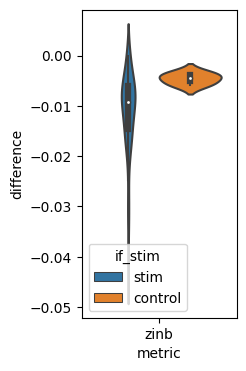

In [11]:
import pandas as pd
df=pd.DataFrame({'difference':differece0, 'if_stim':if_stim0, 'metric':metric0})
plt.figure(figsize=(2, 4))
# import seaborn as sns
# box_plot=sns.boxplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('box-output.png')
# strip_plot=sns.stripplot(data=df,x="metric", y="difference",c='r', hue="if_stim")
# plt.savefig('strip-output.png')
violin_plot=sns.violinplot(data=df,x="metric", y="difference", hue="if_stim")
plt.savefig('violin-output.png')


In [39]:
def log_zinb(adata, conditions,stim_str,sample_ctrl=False,ctrl1=None,ctrl2=None):
    
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
        
    x,y=dist_based(x,y)

    output=[]
    
    for i in range(x.shape[0]):
#         print(x[i].shape)
#         plt.hist(x[i],bins=30)
#         plt.yscale('log')
#         plt.show()


        if all(elem == 0 for elem in x[i]):
            continue 
        if all(elem == 0 for elem in y[i]):
            continue 

        else:
            one=np.ones_like(x[i])
            model=sm.NegativeBinomialP(x[i],one).fit()
            if model.params[1]>0:
                const_x=model.params[0]
                alpha_x=model.params[1]
                mu=np.exp(const_x)
                theta=1/alpha_x
                p=1/(1+theta)*mu
                logit=np.log((1-p)/p)
                val=log_zinb_positive(torch.tensor(y[i]),torch.tensor(mu),torch.tensor(theta),torch.tensor(logit))
                output.append(torch.mode(val).values.item())
            else:
                continue 

    print(output)
    return output 

test_get_data(log_zinb,train,'zinb')

{'x': 'control', 'y': 'control'}
Optimization terminated successfully.
         Current function value: 0.041648
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.245544
         Iterations: 2
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.648032
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.729012
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.464804
         Iterations: 2
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.073748
         Iterations: 0
         Func

<ipython-input-39-7b1c8ead8882>:33: RuntimeWarning: invalid value encountered in log
  logit=np.log((1-p)/p)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * 

         Current function value: nan
         Iterations: 2
         Function evaluations: 123
         Gradient evaluations: 123
Optimization terminated successfully.
         Current function value: 0.060295
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.410215
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.143978
         Iterations: 2
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.040847
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Current function value: 0.817457
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112
Optimization terminated successfully.
         Current 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_div

         Current function value: nan
         Iterations: 2
         Function evaluations: 121
         Gradient evaluations: 121
Optimization terminated successfully.
         Current function value: 0.341866
         Iterations: 4
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.053617
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Current function value: 0.031659
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112
Optimization terminated successfully.
         Current function value: 0.264235
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.257706
         Iterations: 2
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current fu

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov

         Current function value: 0.439783
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112
Optimization terminated successfully.
         Current function value: 0.009658
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.055918
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.403521
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.017573
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.046467
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Current f

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmod

Optimization terminated successfully.
         Current function value: 0.043797
         Iterations: 1
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.519195
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.491479
         Iterations: 6
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.600578
         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.051481
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.009658
         Iterations: 0
         Function evaluations: 1
         Gr

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid valu

Optimization terminated successfully.
         Current function value: 0.373646
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.704759
         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.591956
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.066320
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Current function value: 0.585784
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 112
Optimization terminated successfully.
         Current function value: 1.148321
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
Optimization

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in true_divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: invalid value encountered in true_divide
  y / mu)
/usr/local/lib/python3.10/d

Optimization terminated successfully.
         Current function value: 0.558076
         Iterations: 6
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.572924
         Iterations: 3
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.485088
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.013551
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.555490
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.024830
         Iterations: 0
         Function evaluations: 1
         Grad

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWar

SyntaxError: ignored

In [32]:
name='control0'
df=pd.read_csv(name+'df.csv')
print(df)
x=np.loadtxt(name+'datax.csv', delimiter=',')
y=np.loadtxt(name+'datay.csv', delimiter=',')
for i in range(x.shape[0]):
  const_x=df["const_x"]
  alpha_x=df["alpha_x"]
  print(compute_log_zinb(y[i],const_x[i],alpha_x[i]))
  

       alpha_x   const_x    alpha_y   const_y
0    35.297595 -4.375757  98.498898 -5.292048
1    37.461825 -2.259502  25.328542 -2.429847
2    37.572715 -0.059603  22.278145 -0.054277
3    22.350634 -0.150384  20.991850 -0.073044
4    15.256475 -1.603168  13.493804 -1.380025
..         ...       ...        ...       ...
94    0.050000 -6.678342   0.037041 -5.292048
95    8.055915 -1.011915   9.296252 -1.083631
96    5.444632 -3.905753        NaN       NaN
97   25.304304 -3.542848  57.526737 -2.583998
98  695.499843 -4.598901        NaN       NaN

[99 rows x 4 columns]


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


RuntimeError: ignored

In [20]:
from pandas._libs.tslibs.offsets import YearBegin
import torch.nn.functional as F
def compute_log_zinb(x,const_x,alpha_x):
    mu=np.exp(const_x)
    theta=1/alpha_x
    p=1/(1+theta)*mu
    logit=np.log((1-p)/p)
    x_val=log_zinb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta),torch.tensor(logit))
    most_frequent=torch.mode(x_val).values.item()
    if p<1:
      most_frequent=0
    return most_frequent 

def load_saved_data():
    list_stim=list(train.obs['perturbation'].unique())
    list_stim.remove('control')
    """
        pair0: c1,c2
        pair1: c1,c3
        pair2: c2,c3
        fit x and plug in y
        """
    for i in range(3): 
      name='control'+str(i)
      x=np.loadtxt(name+'datax.csv', delimiter=',')
      y=np.loadtxt(name+'datay.csv', delimiter=',')
      df=pd.read_csv(name+'df.csv')
      print(x)
  
      res=[]
      out=[]
      for i in range(y.shape[0]):
        print("shape",x[i].shape,y[i].shape)
        if all(elem == 0 for elem in y[i]):
            continue 
        else:
            if df['alpha_x'] is None:
                continue 
            else:
              output=compute_log_zinb(y[i],df['const_x'],df['alpha_x'])
              out.append(output)
              
      res.append(np.mean(out))
    return np.mean(res)


load_saved_data() 

[[0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 [6. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape (795,) (795,)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


RuntimeError: ignored